In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import phik

In [56]:
# https://github.com/rishabhrao1997/Home-Credit-Default-Risk

In [57]:
# set display options
pd.set_option('display.max_row', 120)
pd.set_option('display.max_column', 120)

In [58]:
# import data
application_train = pd.read_csv('data_P7/application_train.csv')
bureau_balance = pd.read_csv('data_P7/bureau_balance.csv')
bureau = pd.read_csv('data_P7/bureau.csv')
credit_card_balance = pd.read_csv('data_P7/credit_card_balance.csv')
HomeCredit_columns = pd.read_csv('data_P7/HomeCredit_columns_description.csv', encoding='latin1')
installments_payments = pd.read_csv('data_P7/installments_payments.csv')
POS_CASH_balance = pd.read_csv('data_P7/POS_CASH_balance.csv')
previous_application = pd.read_csv('data_P7/previous_application.csv')

In [59]:
# Set colors for plots
light_blue = '#2AC3F3'
blue_green = '#6BD8B6'
green = '#A9E04B'
dark_blue = '#004591'
yellow = '#F3C744'
red = '#F37768'
gray = '#7C8894'
colors = [light_blue, green, dark_blue, blue_green,red, yellow, gray,]

In [60]:
HomeCredit_columns.iloc[59]

Unnamed: 0                                                    62
Table                               application_{train|test}.csv
Row                                            BASEMENTAREA_MODE
Description    Normalized information about building where th...
Special                                               normalized
Name: 59, dtype: object

# Exploratory Data Analysis

## Functions

In [61]:
def display_var_def(var_name):
    '''function to display the definition of a variable in application_train.csv 
    using definition from HomeCredit_columns_description.csv'''
    
    df = HomeCredit_columns
    display(df[df['Row'] == var_name]['Description'].values[0])

In [201]:
display_var_def('CNT_PAYMENT')

'Loan annuity'

In [63]:
class checking_nan:
    '''class and function to calculate the rate of NaNs in a df and display plots'''
    
    def __init__(self, df):
        self.df = df
        self.percent_nan = (self.df.isna().sum()/self.df.shape[0])\
            .sort_values(ascending=False)

    def heatmap(self, figsize=(20, 10)):
        plt.figure(figsize=figsize)
        sns.heatmap(self.df.isnull(), cbar=False)
        plt.show()

    def info(self):
        col_with_nan = (self.percent_nan != 0).sum()
        print(
            'Number of columns with NaN: {} / {} columns'.format(col_with_nan, self.df.shape[1]))

    def plot(self, figsize=(20, 5)):
        X = self.percent_nan[self.percent_nan != 0]
        X.plot(kind='bar', figsize=figsize)

In [64]:
class correlation_matrix:
    '''class and functions to display correlation matrix for numerical variables and 
    evaluate top correlated variable to TARGET variable using Phik-Correlation'''

    def __init__(self, df, cols):
        self.df = df
        self.cols = cols

    def heatmap(self, figsize=(15, 15), cmap='OrRd', annot=False):
        columns = ['TARGET'] + self.cols
        self.corr_matrix = self.df[columns].corr()
        plt.figure(figsize=figsize)

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(self.corr_matrix, dtype=bool))
        sns.heatmap(self.corr_matrix, annot=annot, center=0, mask=mask,
                    square=True, linewidths=.1,
                    cbar=True, cbar_kws={"shrink": .2},
                    cmap=cmap)
        plt.show()

    def top_corr_var(self, top_var=10):
        top_corr_df = pd.DataFrame(
            index=self.cols, columns=['Phik-Correlation'])
        for col in self.cols:
            top_corr_df.loc[col, 'Phik-Correlation'] = self.df[['TARGET', col]]\
                .phik_matrix(interval_cols=['TARGET', col]).iloc[0, 1]

        top_corr_df = top_corr_df.sort_values(['Phik-Correlation'], ascending=False)\
            .head(top_var)
        return(top_corr_df)

In [65]:
class phik_matrix:
    '''class and functions to display correlation matrix for categorical variables
    using Phik-Correlation and evaluate top correlated variable to TARGET variable '''

    def __init__(self, df, cols):
        self.df = df
        self.cols = cols

    def heatmap(self, figsize=(15, 15), cmap='OrRd', annot=False):
        columns = ['TARGET'] + self.cols
        data_for_phik = self.df[columns].astype('object')
        self.phik_matrix = data_for_phik.phik_matrix()

        plt.figure(figsize=figsize)

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(self.phik_matrix, dtype=bool))

        sns.heatmap(self.phik_matrix, annot=annot, center=0, mask=mask,
                    square=True, linewidths=.1,
                    cbar=True, cbar_kws={"shrink": .2},
                    cmap=cmap)
        plt.show()

    def top_corr_var(self, top_var=10):
        top_corr_df = pd.DataFrame(
            index=self.cols, columns=['Phik-Correlation'])
        for col in self.cols:
            top_corr_df.loc[col, 'Phik-Correlation'] = self.df[['TARGET', col]]\
                .astype('object')\
                .phik_matrix().iloc[0, 1]

        top_corr_df = top_corr_df.sort_values(['Phik-Correlation'], ascending=False)\
            .head(top_var)
        return(top_corr_df)

In [66]:
def custompieplot(df, col, colors,low_lim, title):
    # prepare data
    X = df[col].value_counts().sort_values(ascending= False)
    fontsize = 14

    # set colors
    n = len(X)
    #cmap = plt.get_cmap(color_map)
    #colors = [cmap(i) for i in np.linspace(0.3, 0.8, n)]

    # create labels
    cond = df[col].value_counts() < low_lim
    low_class_list = df[col].value_counts()[cond].index.tolist()
    labels = [x if x not in low_class_list else 'Others' for x in X.index.tolist()]

    # make pie plot
    plt.pie(x=X, autopct="%.2f%%", explode=[0.02]*n,colors = colors, labels=labels, pctdistance=0.7,
       textprops={'fontsize': fontsize}, startangle=50)
    plt.xlabel(title, fontsize=fontsize, weight='bold')
    
    # add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.4, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

In [67]:
def cat_target_donutplots(df, col):

    fig = plt.figure(figsize=(15,5))

    plt.suptitle(col, fontsize=16, weight='bold')
    plt.subplots_adjust(top=1)
    
    plt.subplot(131)
    custompieplot(df, col, colors,0, 'All Clients')
    
    plt.subplot(132)
    df1 = df[df['TARGET']== 1]
    custompieplot(df1, col, colors,0, 'Defaulters')

    plt.subplot(133)
    df2 = df[df['TARGET']== 0]
    custompieplot(df2, col, colors,0, 'Non Defaulters')

    plt.show()

In [196]:
def cat_target_donutplots2(df, col):

    fig = plt.figure(figsize=(10,5))

    plt.suptitle(col, fontsize=16, weight='bold')
    plt.subplots_adjust(top=1, )
    
    plt.subplot(121)
    df1 = df[df['TARGET']== 1]
    custompieplot(df1, col, colors,0, 'Defaulters')

    plt.subplot(122)
    df2 = df[df['TARGET']== 0]
    custompieplot(df2, col, colors,0, 'Non Defaulters')

    plt.show()

In [68]:
# Bar plot 
def custom_barplot(X, colors):
    X.plot(kind='barh',color = colors, width=0.8)
    for i, v in enumerate(X):
        plt.text(v, i, " "+str(round(v*100,2))+' %', va='center')
    plt.xticks(None)
    plt.ylabel(None)
    plt.xlim(0,X.max()*1.3)
    plt.xlabel(X.name, weight='bold', fontsize = 14)

def cat_target_barplots(df, col, figsize=(16,4), top=0.85):
    
    # create df with number of clients per target and categories
    df = df.groupby([col, 'TARGET'])\
        .size().reset_index()\
        .pivot(columns='TARGET', index=col, values=0)\
        .reset_index().set_index(col)

    # set names and create 'All clients' columns
    df = df.fillna(0)
    df.columns = ['Defaulters', 'Non Defaulters']
    df['All Clients']= df['Defaulters'] + df['Non Defaulters']
    df = df.sort_values('All Clients')
    
    title = col
    if df.shape[0] > 10 :
        df = df.tail(10)
        title = str(col)+ (' - top 10')
    
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16, weight='bold')
    plt.subplots_adjust(top=top)
    
    # plot for all clients
    pop = 'All Clients'
    X = (df[pop]/df[pop].sum())
    ax1 = plt.subplot(131)
    custom_barplot(X, colors)
    
    # plot for Defaulters
    pop = 'Defaulters'
    X = (df[pop]/df[pop].sum())
    ax2 = plt.subplot(132)
    custom_barplot(X, colors)
    ax2.set_yticks([])

    # plot for Non Defaulters
    pop = 'Non Defaulters'
    X = (df[pop]/df[pop].sum())
    ax3 = plt.subplot(133)
    custom_barplot(X, colors)
    ax3.set_yticks([])
    plt.subplots_adjust(wspace = 0.1)

    plt.show()

In [198]:
def cat_target_barplots2(df, col, figsize=(16,4), top=0.85):
    
    # create df with number of clients per target and categories
    df = df.groupby([col, 'TARGET'])\
        .size().reset_index()\
        .pivot(columns='TARGET', index=col, values=0)\
        .reset_index().set_index(col)

    # set names
    df = df.fillna(0)
    df.columns = ['Defaulters', 'Non Defaulters']
    df['All Clients']= df['Defaulters'] + df['Non Defaulters']
    df = df.sort_values('All Clients')
    
    title = '{} - {} classes'.format(col, df.shape[0])
    if df.shape[0] > 10 :
        title = '{} (top 10) - {} classes'.format(col, df.shape[0])
        df = df.tail(10)
    
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title, fontsize=16, weight='bold')
    plt.subplots_adjust(top=top)
    
    # plot for Defaulters
    pop = 'Defaulters'
    X = (df[pop]/df[pop].sum())
    ax1 = plt.subplot(121)
    custom_barplot(X, colors)
    #ax1.set_yticks([])

    # plot for Non Defaulters
    pop = 'Non Defaulters'
    X = (df[pop]/df[pop].sum())
    ax2 = plt.subplot(122)
    custom_barplot(X, colors)
    ax2.set_yticks([])
    plt.subplots_adjust(wspace = 0.1)

    plt.show()

In [69]:
def customboxplot(df, col, Fliers=True, figsize = (7,4)):
    df['TARGET']= df['TARGET'].astype('category')
    sns.boxplot(data = df,x = col, y = 'TARGET', showfliers = Fliers, palette = [red, green])
    plt.xlabel(col, weight = 'bold')
    
def customviolinplot(df, col, Fliers=True, figsize = (7,4)):
    df['TARGET']= df['TARGET'].astype('category')   
    sns.violinplot(data = df,x = col, y = 'TARGET', showfliers = Fliers, palette = [red, green])
    plt.xlabel(col, weight = 'bold')

## application_train

### Shape and variables

- Target : TARGET (1 for defaulter, 0 for non defaulter)
- Rows and columns : 307 511, 122
- Quantitative variables: 65 / Qualitative variables: 16 + 41 = 57 (int as qualitative variables)
- No duplicated rows

In [70]:
application_train.shape

(307511, 122)

In [71]:
application_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,...,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,...,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,...,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

In [72]:
application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

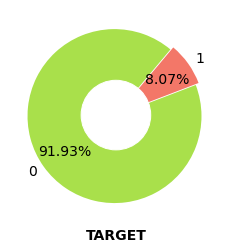

In [73]:
custompieplot(application_train, 'TARGET', [green, red],0, 'TARGET')

In [74]:
application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [75]:
application_train.duplicated().value_counts()

False    307511
dtype: int64

### Missing values

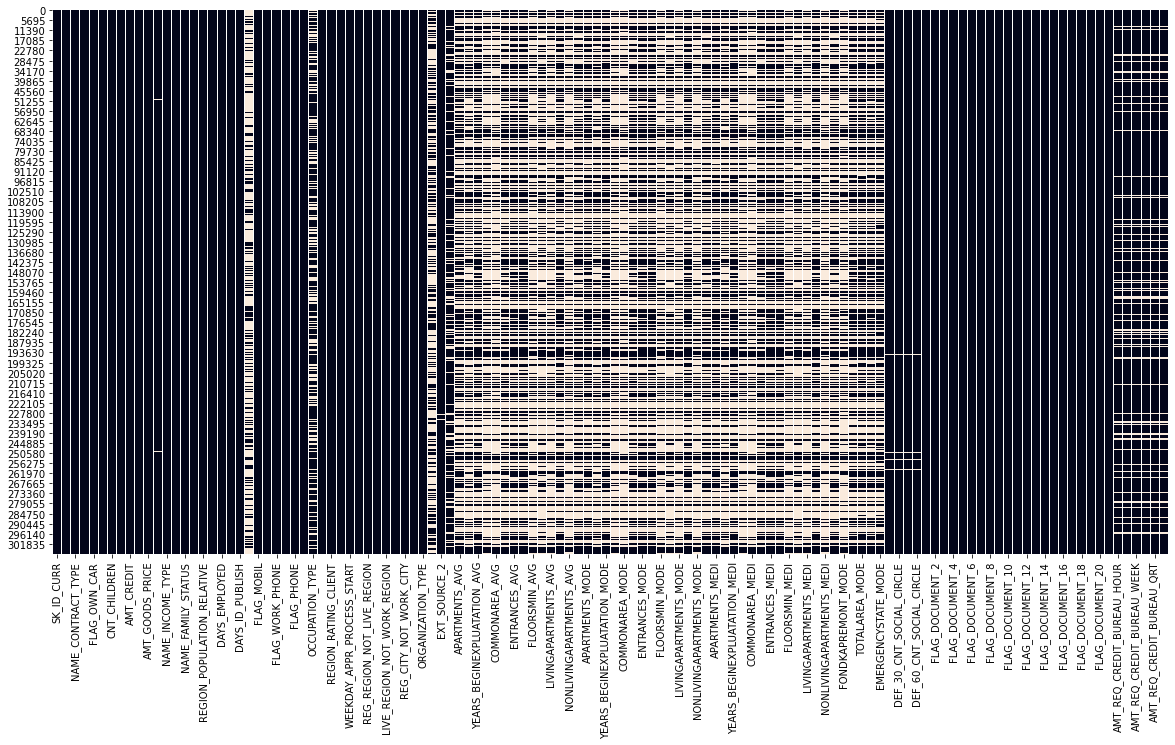

In [76]:
checking_nan(application_train).heatmap()

Number of columns with NaN: 67 / 122 columns


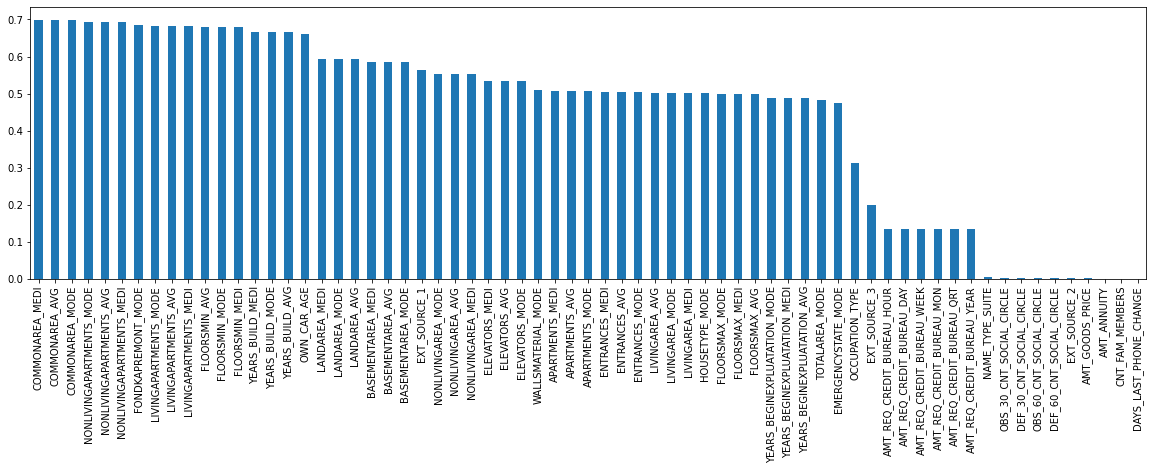

In [77]:
checking_nan(application_train).info()
checking_nan(application_train).plot()

In [78]:
# make a list of variables with less than 20% Nan
percent_nan_application = checking_nan(application_train).percent_nan
var_to_keep = percent_nan_application[percent_nan_application <0.2].index.tolist()
var_to_keep = [x for x in var_to_keep if x != 'SK_ID_CURR']

### Numerical variables

In [79]:
# make a list variables and remove ID variable
variables = application_train.columns
variables = [x for x in variables if x != 'SK_ID_CURR' ]

# make a list of numerical variables
numerical_var = [col for col in variables if application_train.dtypes[col] == 'float']\
    + ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH']

len(numerical_var)

68

In [80]:
# make a list of numerical variables with less than 20% NaN
num_var_to_keep = [var for var in numerical_var if var in var_to_keep]
len(num_var_to_keep)

23

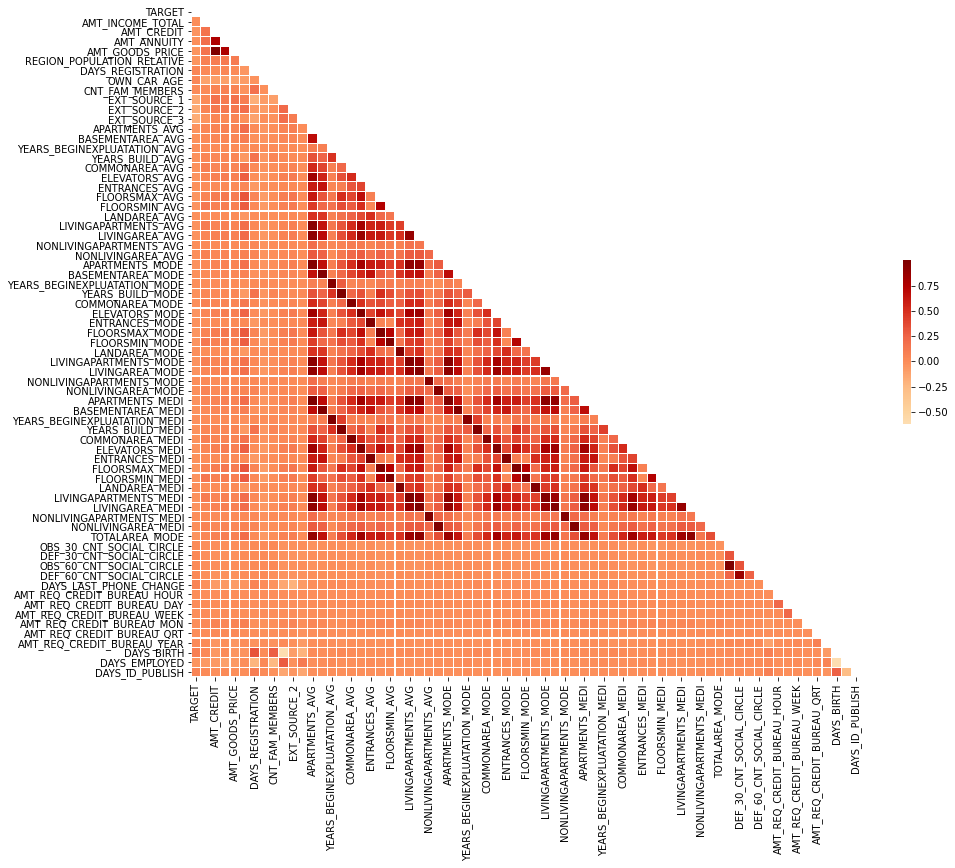

In [81]:
correlation_matrix(application_train, numerical_var).heatmap()

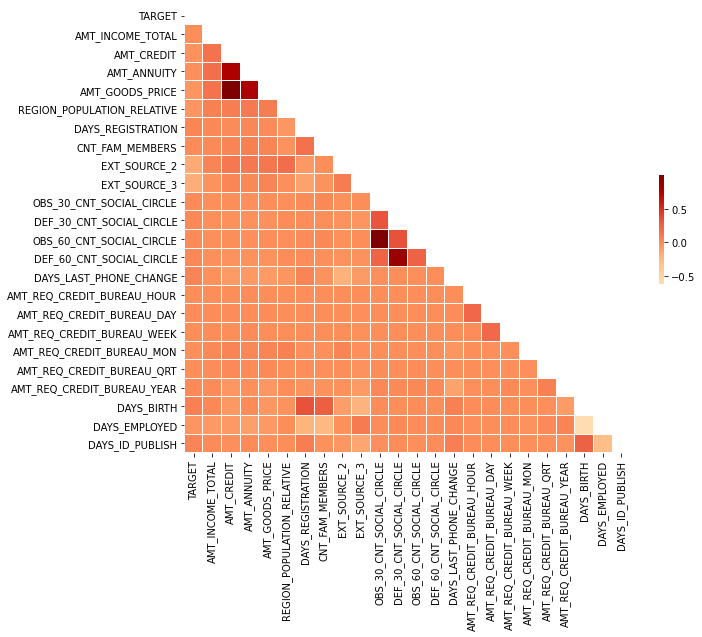

In [82]:
correlation_matrix(application_train, num_var_to_keep).heatmap(figsize = (10,10))

In [83]:
df_top_num_var0 = correlation_matrix(application_train, numerical_var).top_corr_var()
display(df_top_num_var0)

,Phik-Correlation
EXT_SOURCE_3,0.24768
EXT_SOURCE_1,0.217846
EXT_SOURCE_2,0.213965
DAYS_BIRTH,0.102378
DAYS_LAST_PHONE_CHANGE,0.073218
DAYS_EMPLOYED,0.072095
DAYS_ID_PUBLISH,0.067766
AMT_GOODS_PRICE,0.059094
FLOORSMAX_AVG,0.058826
FLOORSMAX_MEDI,0.058595


In [84]:
df_top_num_var = correlation_matrix(application_train, num_var_to_keep).top_corr_var(10)
display(df_top_num_var)

,Phik-Correlation
EXT_SOURCE_3,0.24768
EXT_SOURCE_2,0.213965
DAYS_BIRTH,0.102378
DAYS_LAST_PHONE_CHANGE,0.073218
DAYS_EMPLOYED,0.072095
DAYS_ID_PUBLISH,0.067766
AMT_GOODS_PRICE,0.059094
AMT_CREDIT,0.056794
DAYS_REGISTRATION,0.054589
REGION_POPULATION_RELATIVE,0.04257


In [85]:
df_top_num_var

,Phik-Correlation
EXT_SOURCE_3,0.24768
EXT_SOURCE_2,0.213965
DAYS_BIRTH,0.102378
DAYS_LAST_PHONE_CHANGE,0.073218
DAYS_EMPLOYED,0.072095
DAYS_ID_PUBLISH,0.067766
AMT_GOODS_PRICE,0.059094
AMT_CREDIT,0.056794
DAYS_REGISTRATION,0.054589
REGION_POPULATION_RELATIVE,0.04257


In [86]:
# modify variable DAYS to YEARS
application_eda = application_train.copy()

application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
application_train['YEARS_EMPLOYED'] = application_train['DAYS_EMPLOYED']* -1 / 365
application_train['YEARS_ID_PUBLISH'] = application_train['DAYS_ID_PUBLISH']* -1 / 365
application_train['YEARS_REGISTRATION'] = application_train['DAYS_REGISTRATION']* -1 / 365
application_train['YEARS_LAST_PHONE_CHANGE'] = application_train['DAYS_LAST_PHONE_CHANGE']* -1 / 365

In [87]:
top_num_var = df_top_num_var.index.tolist()

replacements = {
    'DAYS_BIRTH': 'AGE_YEARS',
    'DAYS_EMPLOYED': 'YEARS_EMPLOYED',
    'DAYS_ID_PUBLISH': 'YEARS_ID_PUBLISH',
    'DAYS_REGISTRATION': 'YEARS_REGISTRATION', 
    'DAYS_LAST_PHONE_CHANGE': 'YEARS_LAST_PHONE_CHANGE'}

top_num_var_fe  = [replacements.get(x, x) for x in top_num_var ]

In [88]:
# Statistics for defaulter
df = application_train[application_train['TARGET']==1]
df[top_num_var_fe].median()

EXT_SOURCE_3                       0.379100
EXT_SOURCE_2                       0.440381
AGE_YEARS                         39.128767
YEARS_LAST_PHONE_CHANGE            1.627397
YEARS_EMPLOYED                     2.832877
YEARS_ID_PUBLISH                   7.663014
AMT_GOODS_PRICE               450000.000000
AMT_CREDIT                    497520.000000
YEARS_REGISTRATION                11.112329
REGION_POPULATION_RELATIVE         0.018634
dtype: float64

In [89]:
# Statistics for non-defaulter
df = application_train[application_train['TARGET']==0]
df[top_num_var_fe].median()

EXT_SOURCE_3                       0.546023
EXT_SOURCE_2                       0.573905
AGE_YEARS                         43.498630
YEARS_LAST_PHONE_CHANGE            2.126027
YEARS_EMPLOYED                     3.383562
YEARS_ID_PUBLISH                   9.027397
AMT_GOODS_PRICE               450000.000000
AMT_CREDIT                    517788.000000
YEARS_REGISTRATION                12.449315
REGION_POPULATION_RELATIVE         0.018850
dtype: float64

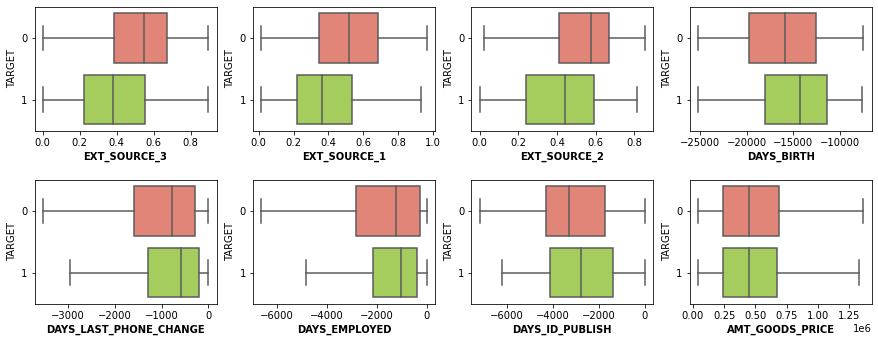

In [137]:
plt.figure(figsize=(15,15))
df = application_train
variables = df_top_num_var0.index[:8]

# plt.suptitle('Top10 correlated numerical variables', fontsize = 20)

for i, var in enumerate(variables):
    n = len(variables)
    plt.subplot(int(n/2)+1, 4, i+1)
    customboxplot(df, var, Fliers=False)
plt.subplots_adjust(hspace = 0.4)

EXT_SOURCE_3


'Normalized score from external data source'

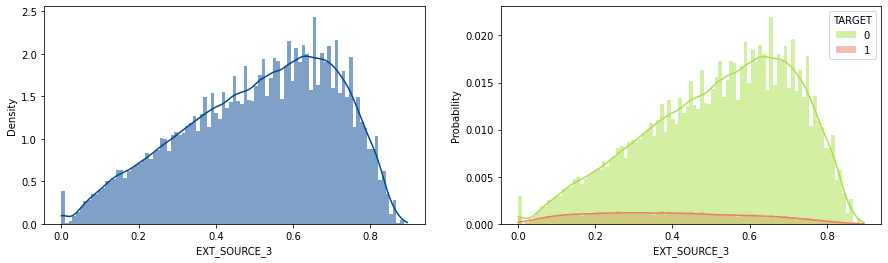

EXT_SOURCE_2


'Normalized score from external data source'

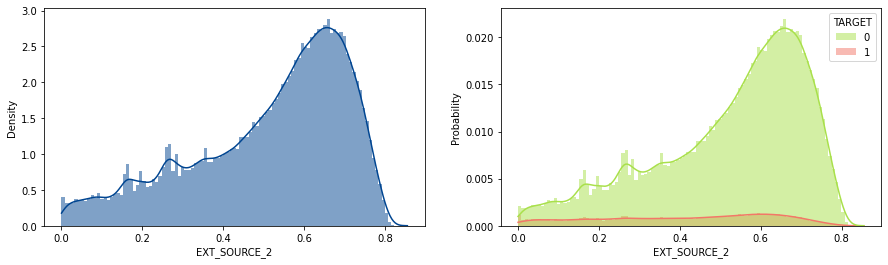

DAYS_BIRTH --> AGE_YEARS


"Client's age in days at the time of application"

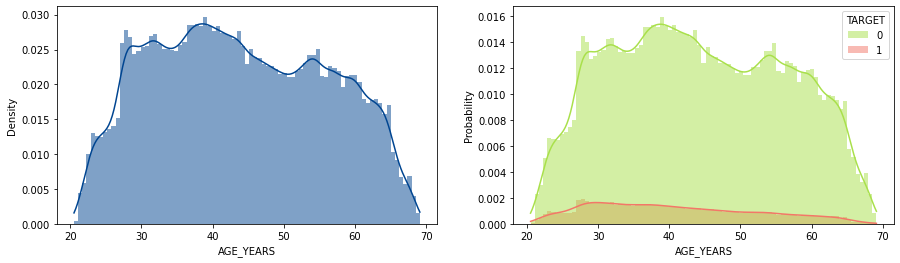

DAYS_LAST_PHONE_CHANGE --> YEARS_LAST_PHONE_CHANGE


'How many days before application did client change phone'

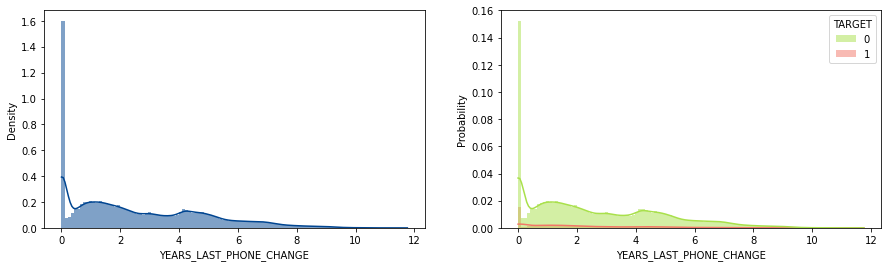

DAYS_EMPLOYED --> YEARS_EMPLOYED


'How many days before the application the person started current employment'

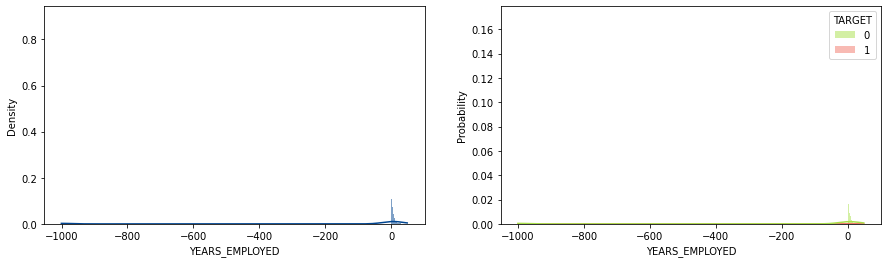

DAYS_ID_PUBLISH --> YEARS_ID_PUBLISH


'How many days before the application did client change the identity document with which he applied for the loan'

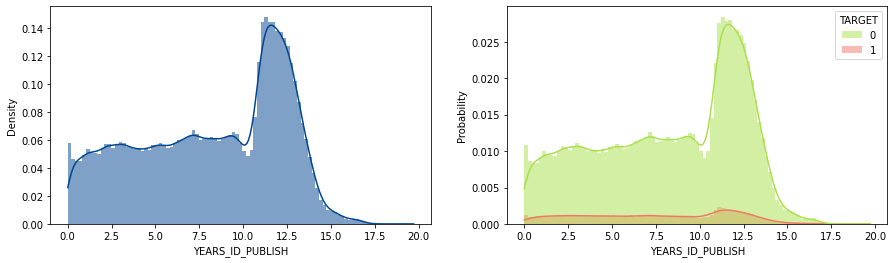

AMT_GOODS_PRICE


'For consumer loans it is the price of the goods for which the loan is given'

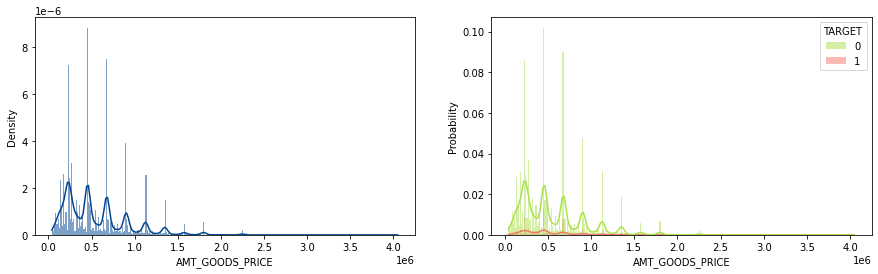

AMT_CREDIT


'Credit amount of the loan'

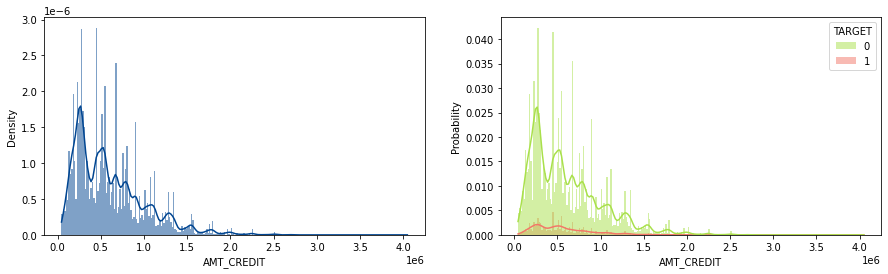

DAYS_REGISTRATION --> YEARS_REGISTRATION


'How many days before the application did client change his registration'

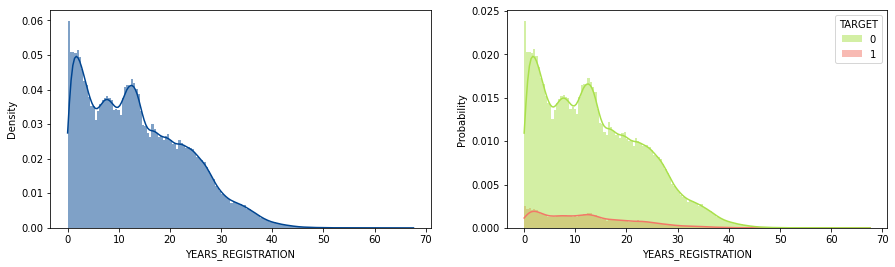

REGION_POPULATION_RELATIVE


'Normalized population of region where client lives (higher number means the client lives in more populated region)'

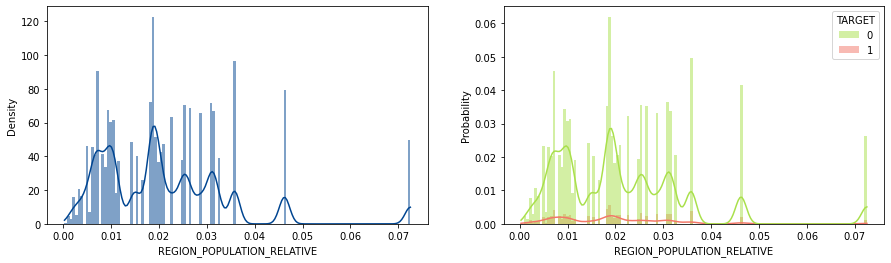

In [223]:
# distribution plots
for col, col_fe in zip(top_num_var, top_num_var_fe)  : 
    if col != col_fe :
        print(str(col) +  ' --> ' + str(col_fe))
    else: 
        print(col)
    display_var_def(col)
    
    plt.figure(figsize = (15,4))
    plt.subplot(121)
    sns.histplot(x = col_fe, data = application_train, kde = True, stat="density", linewidth=0,
             color = dark_blue)
    plt.subplot(122)
    sns.histplot(x = col_fe, data = application_train, hue = 'TARGET', kde = True, stat="density", linewidth=0, 
             palette = [green, red])
    plt.show()

In [26]:
# Most likely some errros 
(application_train['DAYS_EMPLOYED']== 365243).value_counts()
# 365243 days = 1000 years ....

False    252137
True      55374
Name: DAYS_EMPLOYED, dtype: int64

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

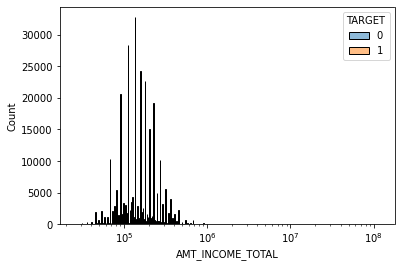

In [220]:
sns.histplot(data = application_train, x = 'AMT_INCOME_TOTAL', log_scale = 10, hue = 'TARGET')

In [27]:
application_train[application_train['AMT_INCOME_TOTAL']> 10000000 ]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,...,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS,YEARS_EMPLOYED,YEARS_ID_PUBLISH,YEARS_REGISTRATION,YEARS_LAST_PHONE_CHANGE
12840,114967,1,Cash loans,F,N,Y,1,117000000.0,562491.0,26194.5,454500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010643,-12615,-922,-6762.0,-3643,NaN,1,1,0,1,0,0,Laborers,3.0,2,2,TUESDAY,14,0,0,0,0,0,0,Business Entity Type 3,0.460809,0.113161,0.145543,0.1031,0.0947,0.9791,NaN,NaN,0.0,0.2069,0.1667,NaN,0.0688,NaN,0.0615,NaN,NaN,0.105,0.0983,...,0.0704,NaN,0.0641,NaN,NaN,0.1041,0.0947,0.9791,NaN,NaN,0.0,0.2069,0.1667,NaN,0.07,NaN,0.0626,NaN,NaN,NaN,block of flats,0.0715,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,34.561644,2.526027,9.980822,18.526027,-0.000000
203693,336147,0,Cash loans,M,Y,Y,2,18000090.0,675000.0,69295.5,675000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.030755,-15704,-4961,-3338.0,-4728,7.0,1,1,0,1,0,0,NaN,4.0,2,2,THURSDAY,22,0,0,0,0,0,0,Business Entity Type 3,0.543417,0.788606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,-1133.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.024658,13.591781,12.953425,9.145205,3.104110
246858,385674,0,Cash loans,M,Y,Y,0,13500000.0,1400503.5,130945.5,1368000.0,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,0.030755,-13551,-280,-3953.0,-4972,10.0,1,1,1,1,0,0,NaN,2.0,2,2,SUNDAY,12,0,0,0,0,0,0,Business Entity Type 3,NaN,0.713507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-13.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,37.126027,0.767123,13.621918,10.830137,0.035

### Categorical variables

In [28]:
# make a liste of numerical variables
categorical_var = [col for col in variables if
                   col not in numerical_var and col != 'TARGET']
len(categorical_var)

52

In [29]:
# make a list of categorical variables with less than 20% NaN
cat_var_to_keep = [var for var in categorical_var if var in var_to_keep]
len(cat_var_to_keep)

47

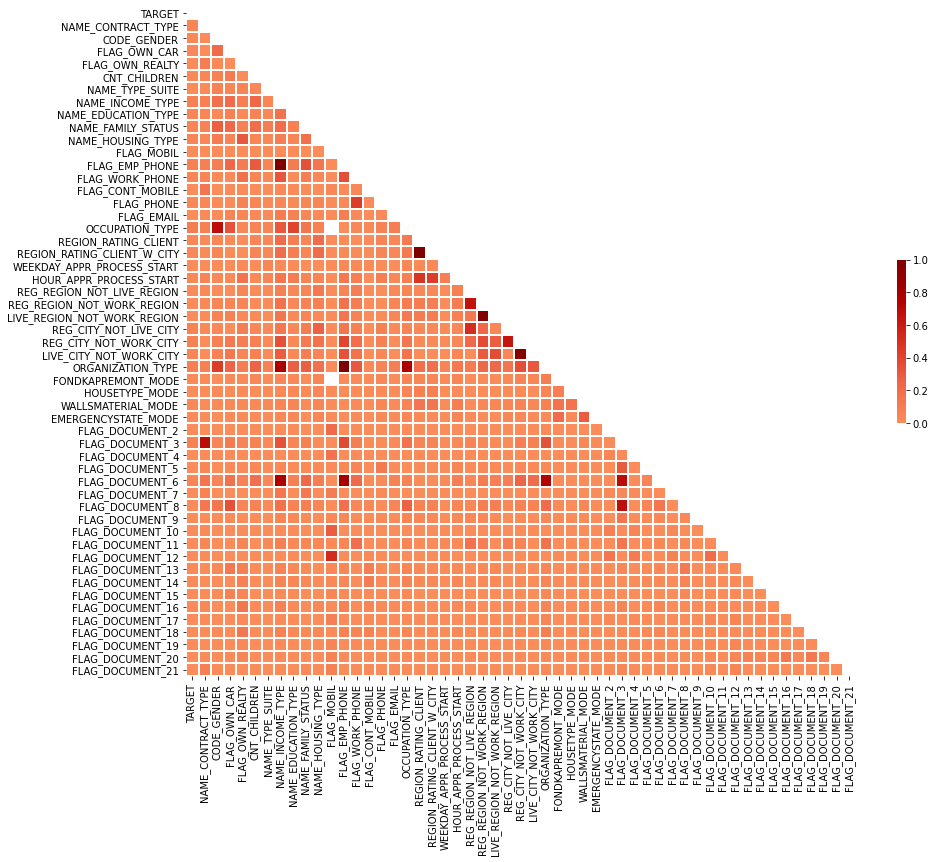

In [248]:
phik_matrix(application_train, categorical_var).heatmap()

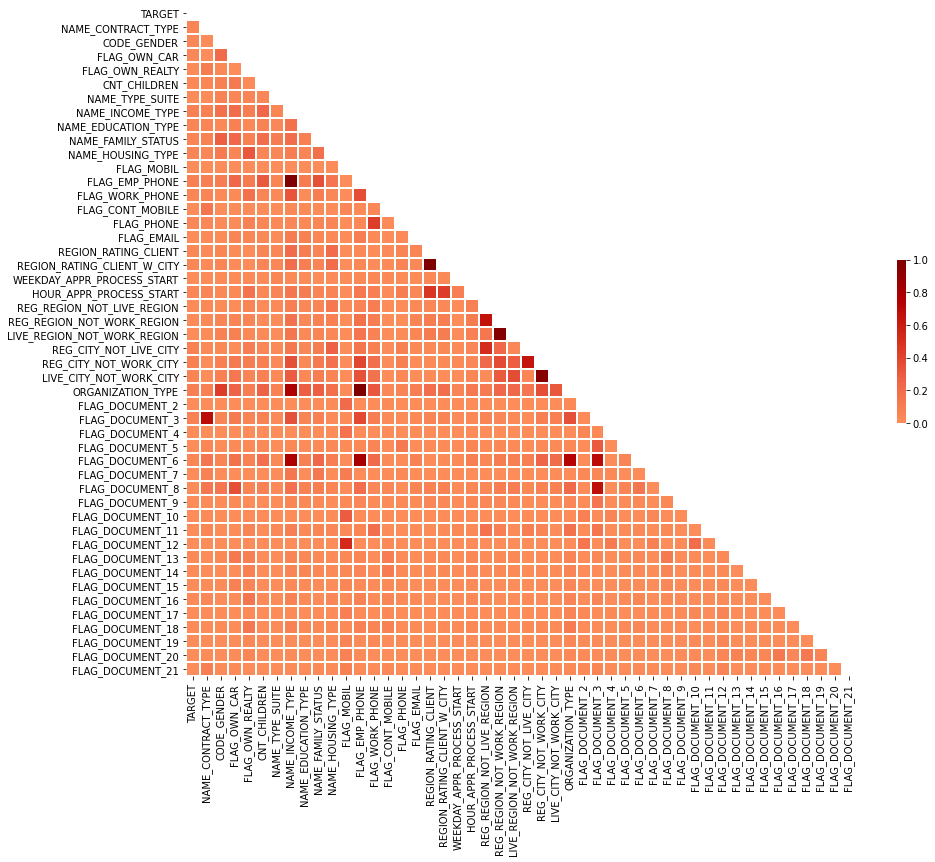

In [269]:
phik_matrix(application_train, cat_var_to_keep).heatmap(figsize = (10,10))

In [289]:
phik_matrix(application_train, categorical_var).top_corr_var()

,Phik-Correlation
OCCUPATION_TYPE,0.102846
ORGANIZATION_TYPE,0.089164
NAME_INCOME_TYPE,0.084831
REG_CITY_NOT_WORK_CITY,0.079946
FLAG_EMP_PHONE,0.072087
REG_CITY_NOT_LIVE_CITY,0.069588
FLAG_DOCUMENT_3,0.069525
NAME_FAMILY_STATUS,0.056043
NAME_HOUSING_TYPE,0.051107
LIVE_CITY_NOT_WORK_CITY,0.050956


In [30]:
df_top_cat_var = phik_matrix(application_train, cat_var_to_keep).top_corr_var()
df_top_cat_var

,Phik-Correlation
ORGANIZATION_TYPE,0.089164
NAME_INCOME_TYPE,0.084831
REG_CITY_NOT_WORK_CITY,0.079946
FLAG_EMP_PHONE,0.072087
REG_CITY_NOT_LIVE_CITY,0.069588
FLAG_DOCUMENT_3,0.069525
NAME_FAMILY_STATUS,0.056043
NAME_HOUSING_TYPE,0.051107
LIVE_CITY_NOT_WORK_CITY,0.050956
NAME_CONTRACT_TYPE,0.048399


In [31]:
top_cat_var = df_top_cat_var.index.tolist()

ORGANIZATION_TYPE
Number of unique categories: 58


'Type of organization where client works'

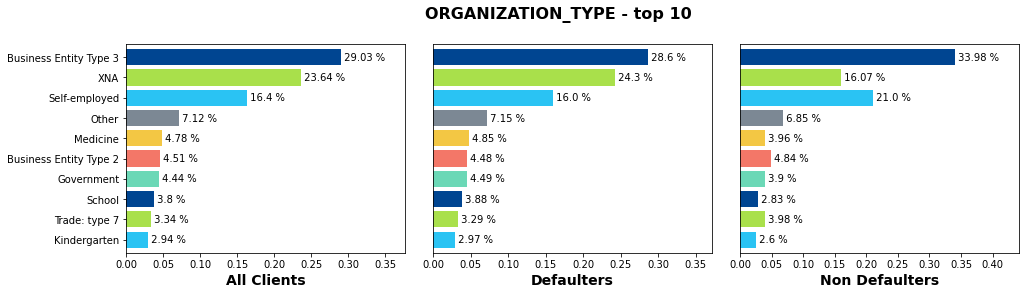

NAME_INCOME_TYPE
Number of unique categories: 8


'Clients income type (businessman, working, maternity leave,�)'

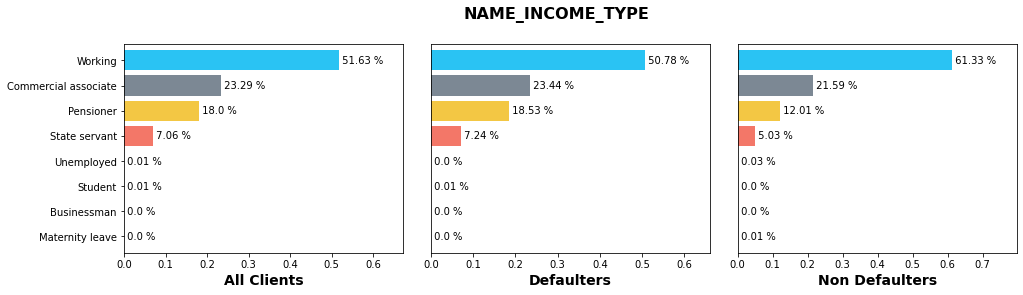

REG_CITY_NOT_WORK_CITY
Number of unique categories: 2


"Flag if client's permanent address does not match work address (1=different, 0=same, at city level)"

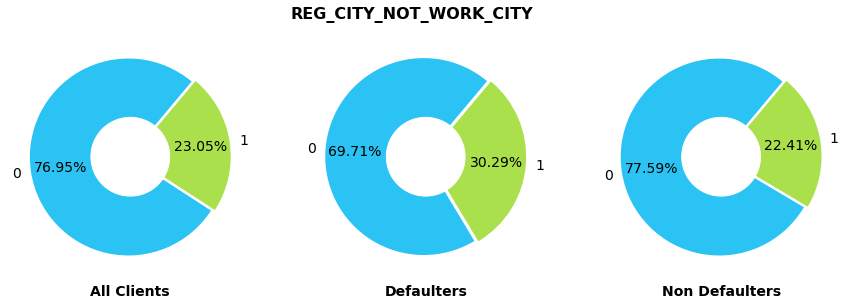

FLAG_EMP_PHONE
Number of unique categories: 2


'Did client provide work phone (1=YES, 0=NO)'

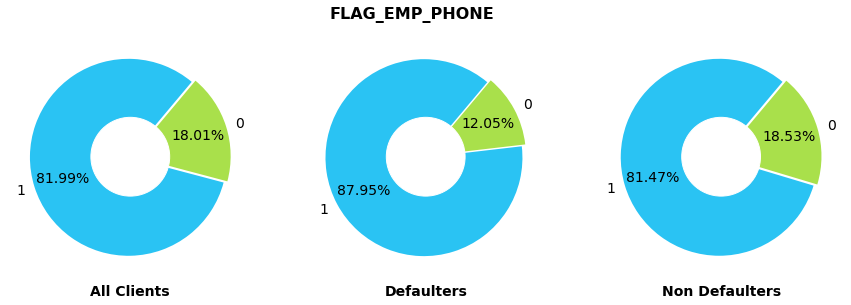

REG_CITY_NOT_LIVE_CITY
Number of unique categories: 2


"Flag if client's permanent address does not match contact address (1=different, 0=same, at city level)"

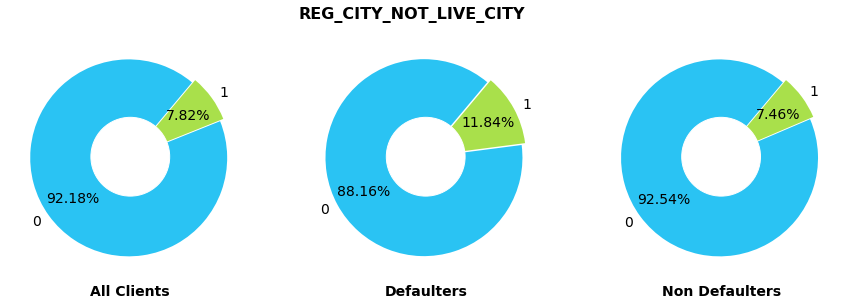

FLAG_DOCUMENT_3
Number of unique categories: 2


'Did client provide document 3'

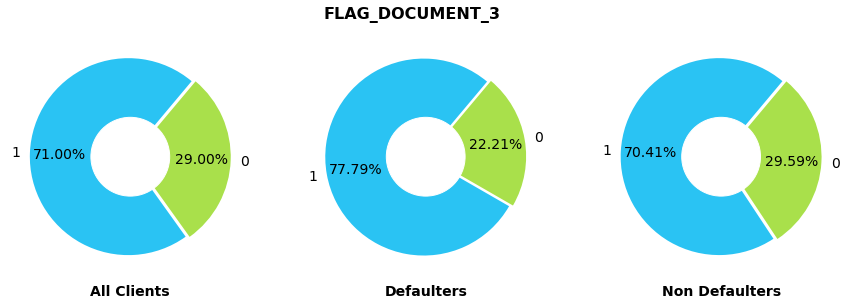

NAME_FAMILY_STATUS
Number of unique categories: 6


'Family status of the client'

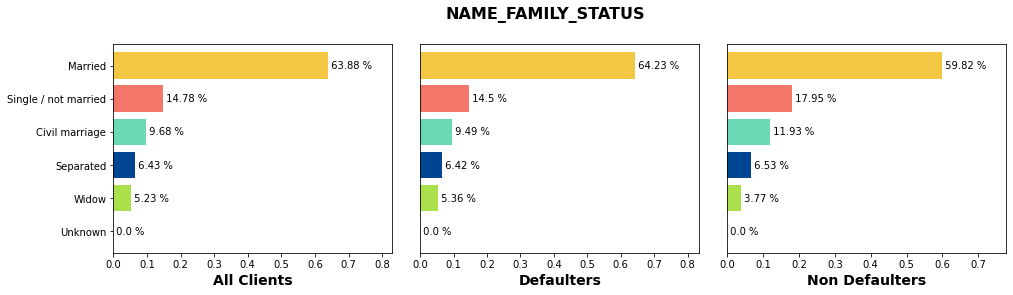

NAME_HOUSING_TYPE
Number of unique categories: 6


'What is the housing situation of the client (renting, living with parents, ...)'

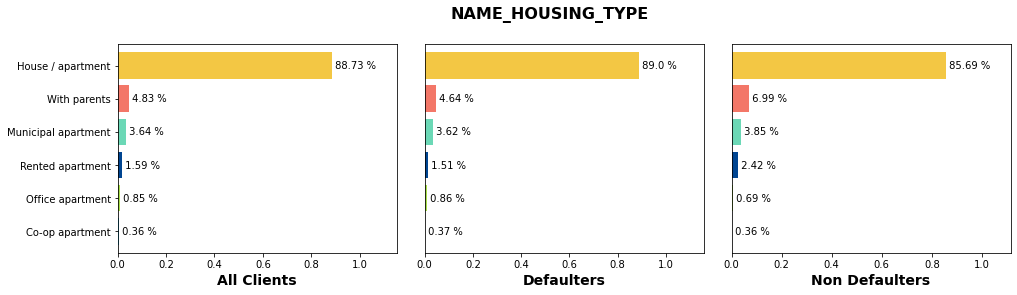

LIVE_CITY_NOT_WORK_CITY
Number of unique categories: 2


"Flag if client's contact address does not match work address (1=different, 0=same, at city level)"

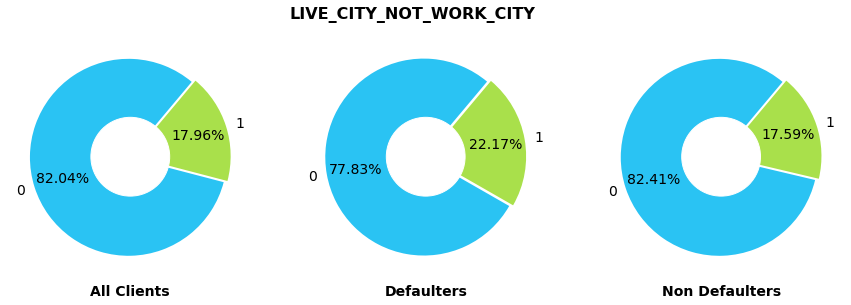

NAME_CONTRACT_TYPE
Number of unique categories: 2


'Identification if loan is cash or revolving'

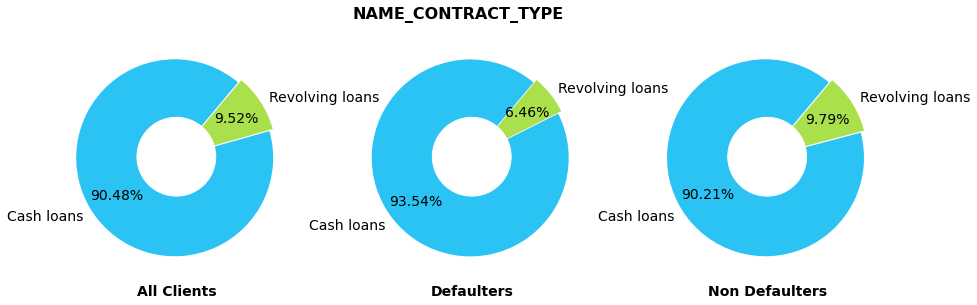

In [36]:
# donut or bar plots for top categorical features
for col in top_cat_var : 
    n = len(application_train[col].unique())
    print(col)
    print('Number of unique categories: {}'.format(n))
    display_var_def(col)
    if n <= 2:
        cat_target_donutplots(application_train, col)
    else :
        cat_target_barplots(application_train, col)

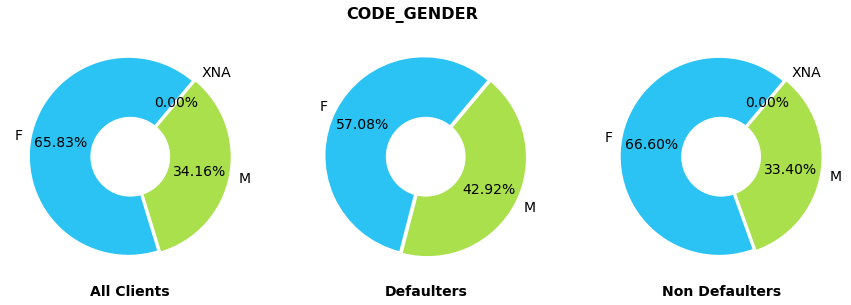

In [37]:
# Other variables
cat_target_donutplots(application_train, 'CODE_GENDER')

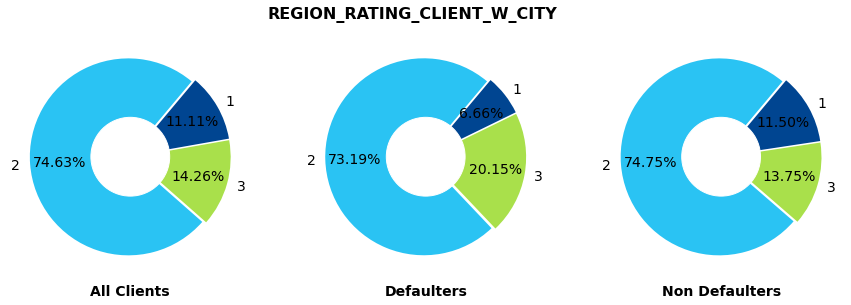

In [38]:
cat_target_donutplots(application_train, 'REGION_RATING_CLIENT_W_CITY')

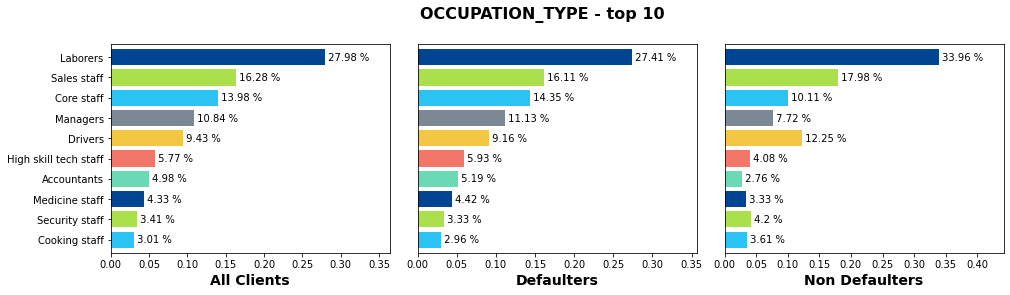

In [39]:
cat_target_barplots(application_train, 'OCCUPATION_TYPE')

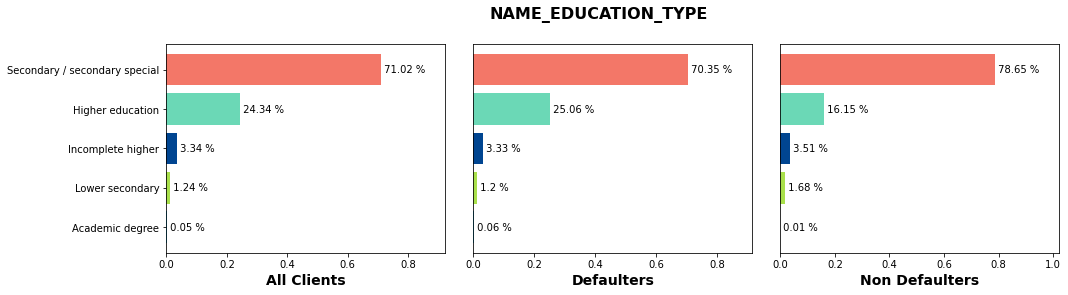

In [40]:
cat_target_barplots(application_train, 'NAME_EDUCATION_TYPE')

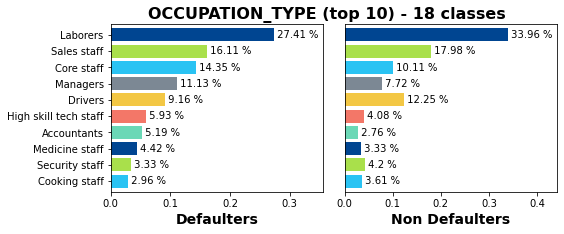

In [174]:
cat_target_barplots2(application_train, 'OCCUPATION_TYPE', figsize=(8,3), top=0.9)

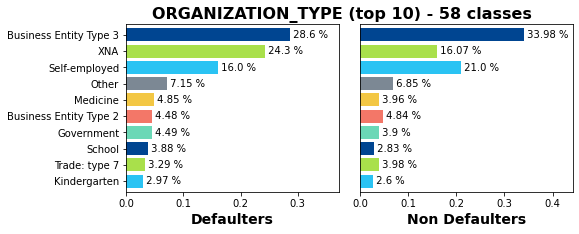

In [173]:
cat_target_barplots2(application_train, 'ORGANIZATION_TYPE', figsize=(8,3), top=0.9)

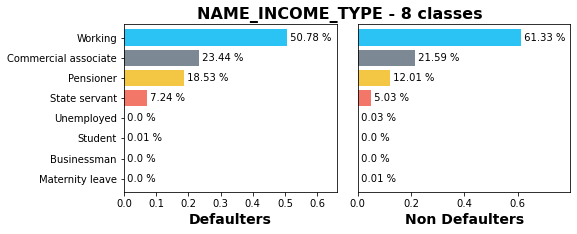

In [199]:
cat_target_barplots2(application_train, 'NAME_INCOME_TYPE', figsize=(8,3), top=0.9)

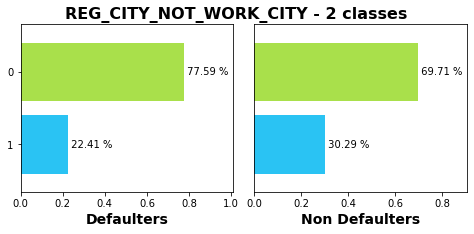

In [200]:
cat_target_barplots2(application_train, 'REG_CITY_NOT_WORK_CITY', figsize=(8,3), top=0.9)

## bureau.csv

### Shape, variables & NaN
- Rows and columns : 1 716 428, 17
- Numerical variables: float 8 / int 6, categorical variables: 3
- No duplicated rows
- 7 columns with NaN (max 70%)

In [41]:
bureau.shape

(1716428, 17)

In [42]:
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [43]:
bureau.dtypes.value_counts()

float64    8
int64      6
object     3
dtype: int64

In [44]:
bureau.duplicated().value_counts()

False    1716428
dtype: int64

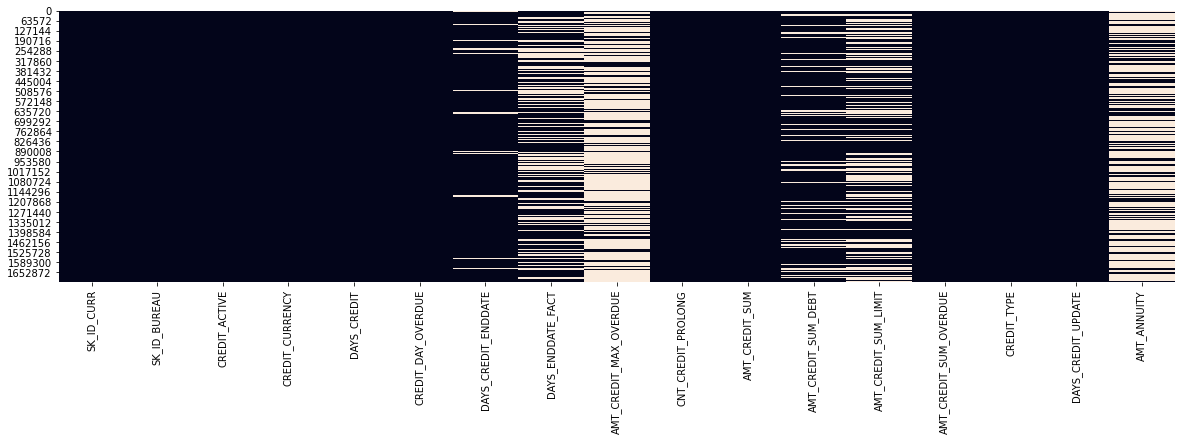

In [83]:
checking_nan(bureau).heatmap(figsize = (20,5))

Number of columns with NaN: 7 / 17 columns


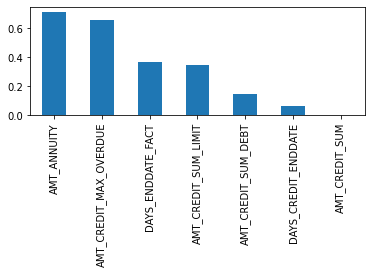

In [87]:
checking_nan(bureau).info()
checking_nan(bureau).plot(figsize = (6,2))

In [45]:
# print number of client in bureau.csv
SK_ID_CURR_bureau = bureau['SK_ID_CURR'].unique().tolist()
len(SK_ID_CURR_bureau)

305811

In [46]:
# check number of clients that are in application_train and who have bureau history
CURR_ID_with_bureau_history = application_train[application_train['SK_ID_CURR'].isin(SK_ID_CURR_bureau)]
CURR_ID_with_bureau_history.shape[0]

263491

In [47]:
bureau_eda = application_train[['SK_ID_CURR', 'TARGET']].merge(bureau, how = 'left')

In [48]:
bureau_eda.head(5)

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.000,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0
3,100002,1,6158907.0,Closed,currency 1,-1121.0,0.0,-911.0,-911.0,3321.000,0.0,19071.0,NaN,NaN,0.0,Consumer credit,-906.0,0.0
4,100002,1,6158908.0,Closed,currency 1,-645.0,0.0,85.0,-36.0,5043.645,0.0,120735.0,0.0,0.0,0.0,Consumer credit,-34.0,0.0


In [535]:
len(bureau_eda['SK_ID_CURR'].unique())

307511

### Numerical variables

In [49]:
bureau_eda.head(3)

,SK_ID_CURR,TARGET,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,100002,1,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,6158905.0,Closed,currency 1,-476.0,0.0,NaN,-48.0,NaN,0.0,0.0,0.0,NaN,0.0,Credit card,-47.0,NaN
2,100002,1,6158906.0,Closed,currency 1,-1437.0,0.0,-1072.0,-1185.0,0.0,0.0,135000.0,0.0,0.0,0.0,Consumer credit,-1185.0,0.0


In [50]:
# create lists of variables
bureau_cat_var = ['CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
var_ID = ['SK_ID_CURR','SK_ID_BUREAU' ]
bureau_num_var = [x for x in bureau.columns if x not in bureau_cat_var and x not in var_ID ]

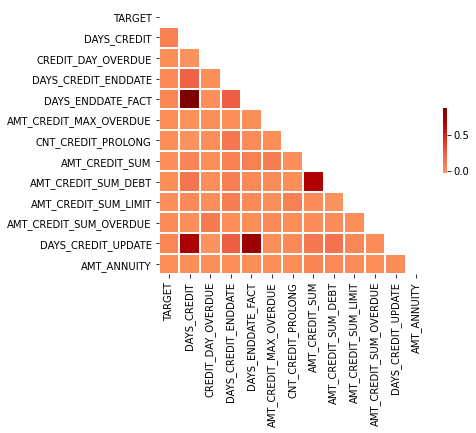

In [549]:
correlation_matrix(bureau_eda, bureau_num_var).heatmap(figsize=(6,6))

In [51]:
df_top_num_var_bureau = correlation_matrix(bureau_eda, bureau_num_var).top_corr_var()
df_top_num_var_bureau

,Phik-Correlation
DAYS_CREDIT,0.088651
DAYS_CREDIT_ENDDATE,0.01898
AMT_CREDIT_SUM_OVERDUE,0.005654
AMT_CREDIT_SUM_LIMIT,0.005192
AMT_CREDIT_MAX_OVERDUE,0.00428
CNT_CREDIT_PROLONG,0.003862
CREDIT_DAY_OVERDUE,0.002528
DAYS_CREDIT_UPDATE,0.002219
AMT_CREDIT_SUM_DEBT,0.001695
AMT_CREDIT_SUM,0.00067


In [52]:
top_num_var_bureau = df_top_num_var_bureau.index.tolist()

DAYS_CREDIT


'How many days before current application did client apply for Credit Bureau credit'

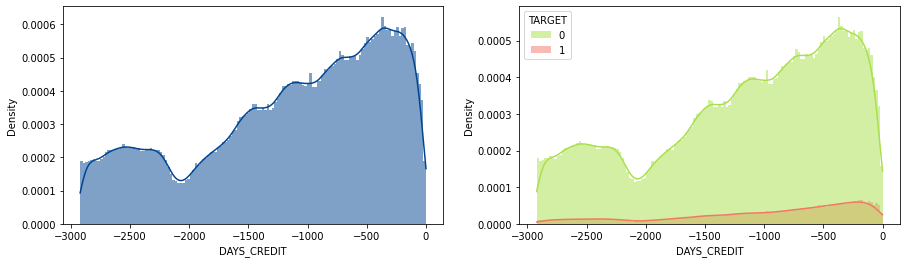

DAYS_CREDIT_ENDDATE


'Remaining duration of CB credit (in days) at the time of application in Home Credit'

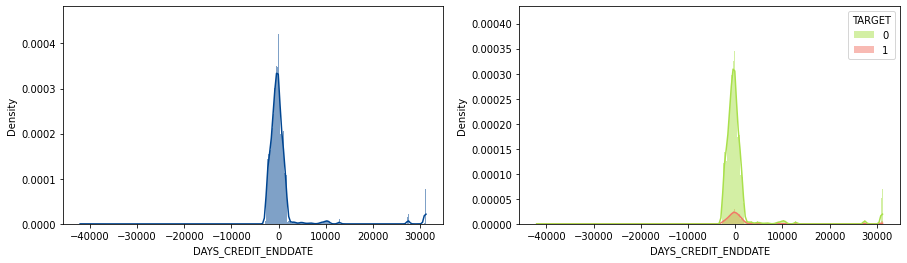

AMT_CREDIT_SUM_OVERDUE


'Current amount overdue on Credit Bureau credit'

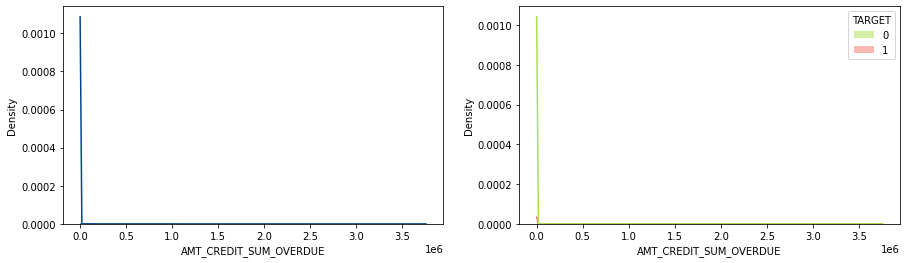

AMT_CREDIT_SUM_LIMIT


'Current credit limit of credit card reported in Credit Bureau'

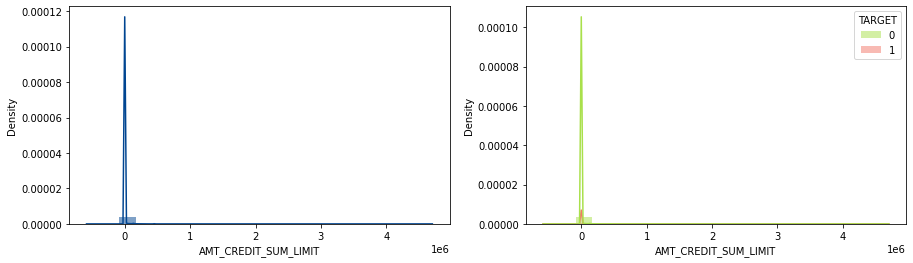

AMT_CREDIT_MAX_OVERDUE


'Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)'

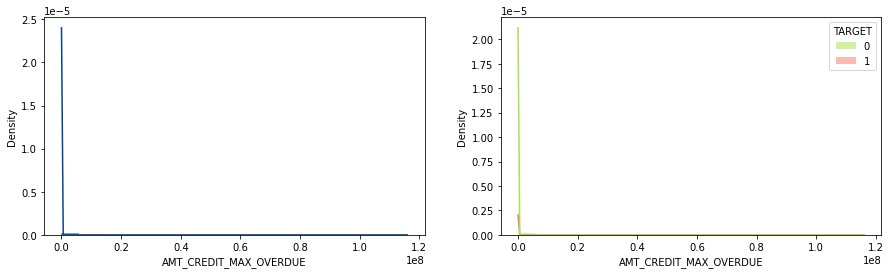

CNT_CREDIT_PROLONG


'How many times was the Credit Bureau credit prolonged'

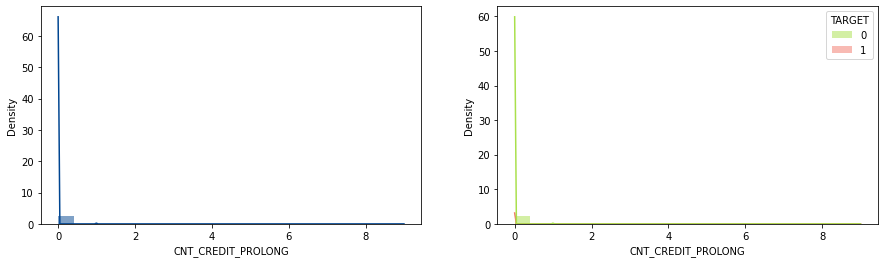

CREDIT_DAY_OVERDUE


'Number of days past due on CB credit at the time of application for related loan in our sample'

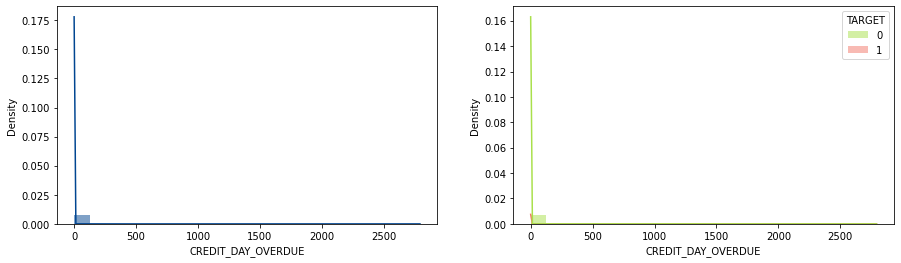

DAYS_CREDIT_UPDATE


'How many days before loan application did last information about the Credit Bureau credit come'

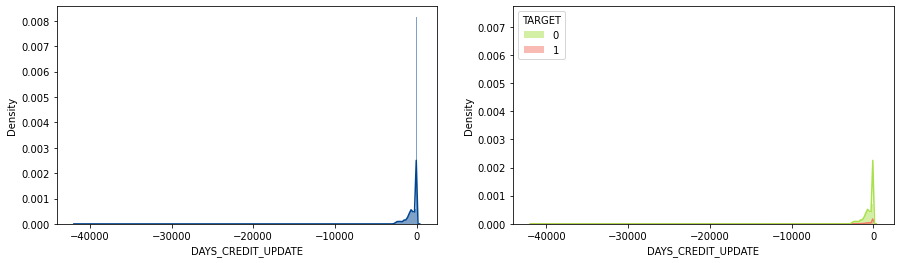

AMT_CREDIT_SUM_DEBT


'Current debt on Credit Bureau credit'

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f9faf727b80> (for post_execute):


KeyboardInterrupt: 

In [555]:
# distribution plots
for col in top_num_var_bureau : 
    print(col)
    display_var_def(col)
    
    plt.figure(figsize = (15,4))
    plt.subplot(121)
    sns.histplot(x = col, data = bureau_eda, kde = True, stat="density", linewidth=0,
             color = dark_blue)
    plt.subplot(122)
    sns.histplot(x = col, data = bureau_eda, hue = 'TARGET', kde = True, stat="density", linewidth=0, 
             palette = [green, red])
    plt.show()

In [ ]:
# some errors 

### Categorical Variables

In [53]:
bureau_cat_var

['CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']

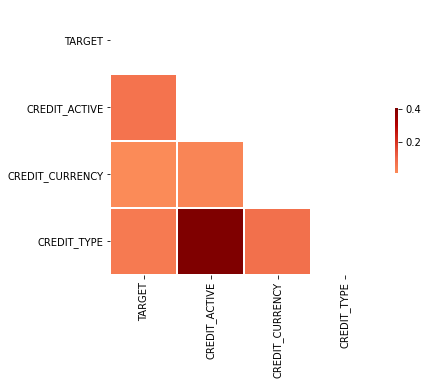

In [54]:
phik_matrix(bureau_eda, bureau_cat_var).heatmap(figsize=(6,6))

In [574]:
phik_matrix(bureau_eda, bureau_cat_var).top_corr_var()

,Phik-Correlation
CREDIT_ACTIVE,0.064481
CREDIT_TYPE,0.049954
CREDIT_CURRENCY,0.004993


CREDIT_ACTIVE
Number of unique categories: 5


'Status of the Credit Bureau (CB) reported credits'

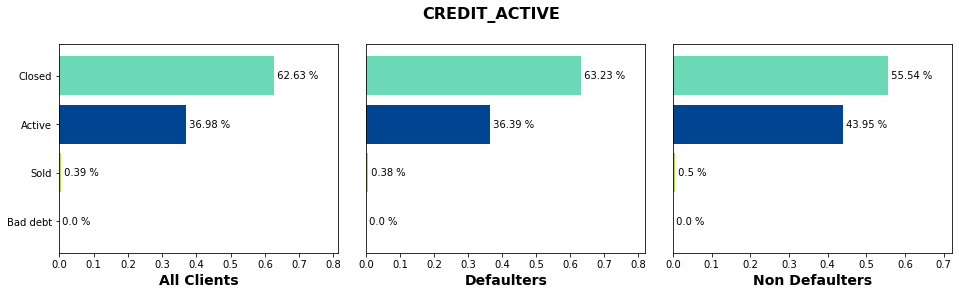

CREDIT_CURRENCY
Number of unique categories: 5


'Recoded currency of the Credit Bureau credit'

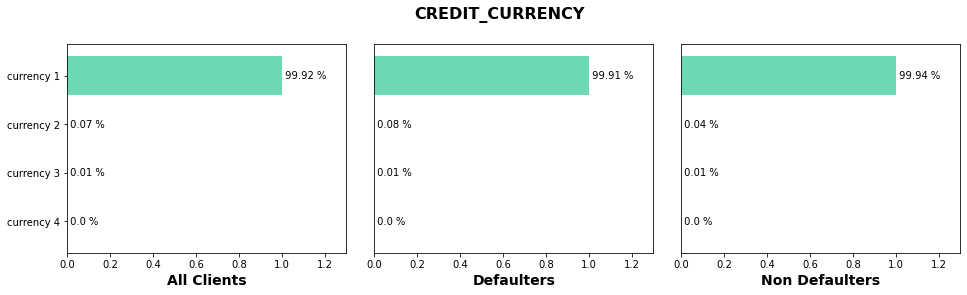

CREDIT_TYPE
Number of unique categories: 16


'Type of Credit Bureau credit (Car, cash,...)'

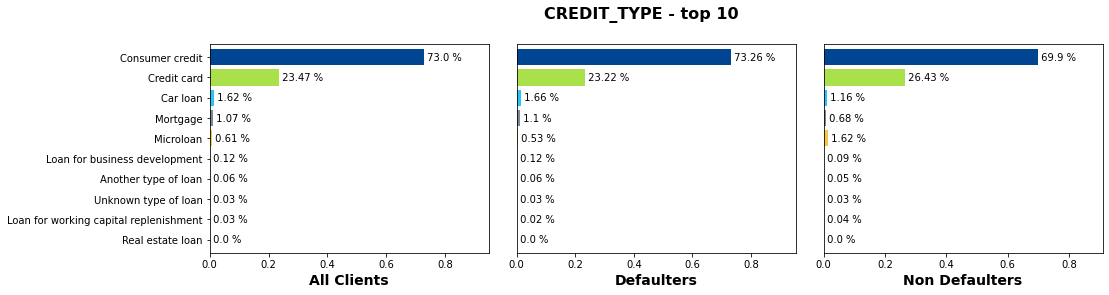

In [570]:
# donut or bar plots for top categorical features
for col in bureau_cat_var : 
    n = len(bureau_eda[col].unique())
    print(col)
    print('Number of unique categories: {}'.format(n))
    display_var_def(col)
    if n <= 2:
        cat_target_donutplots(bureau_eda, col)
    else :
        cat_target_barplots(bureau_eda, col)

## bureau_balance.csv

This table consists of Monthly balance of each credit for each of the previous credit that the client had with financial institutions other than Home Credit.

### Shape, variables & NaN
- Rows and columns : 27 299 925, 3
- Numerical variables: int 2, categorical variables: 1
- No duplicated rows
- No missing values

In [55]:
bureau_balance.shape

(27299925, 3)

In [56]:
bureau_balance.dtypes.value_counts()

int64     2
object    1
dtype: int64

In [57]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [58]:
bureau_balance.duplicated().value_counts()

False    27299925
dtype: int64

In [59]:
checking_nan(bureau_balance).info()

Number of columns with NaN: 0 / 3 columns


### Categorical variables

In [60]:
len(bureau_balance['SK_ID_BUREAU'].unique())

817395

In [61]:
display_var_def('MONTHS_BALANCE')

'Month of balance relative to application date (-1 means the freshest balance date)'

In [62]:
bureau_balance['MONTHS_BALANCE'].unique()

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10, -11, -12,
       -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25,
       -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, -36, -37, -38,
       -39, -40, -41, -42, -43, -44, -45, -46, -47, -48, -49, -50, -51,
       -52, -53, -54, -55, -56, -57, -58, -59, -60, -61, -62, -63, -64,
       -65, -66, -67, -68, -69, -70, -71, -72, -73, -74, -75, -76, -77,
       -78, -79, -80, -81, -82, -83, -84, -85, -86, -87, -88, -89, -90,
       -91, -92, -93, -94, -95, -96])

In [63]:
display_var_def('STATUS')

'Status of Credit Bureau loan during the month (active, closed, DPD0-30,� [C means closed, X means status unknown, 0 means no DPD, 1 means maximal did during month between 1-30, 2 means DPD 31-60,� 5 means DPD 120+ or sold or written off ] )'

In [65]:
bureau_balance['STATUS'].unique()

array(['C', '0', 'X', '1', '2', '3', '5', '4'], dtype=object)

In [66]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [213]:
bureau_balance[bureau_balance['MONTHS_BALANCE'] < -24]['STATUS'].value_counts(normalize = True)

C    0.464231
0    0.292219
X    0.228335
1    0.010104
5    0.002986
2    0.001296
3    0.000505
4    0.000325
Name: STATUS, dtype: float64

## credit_card_balance.csv
This table consists of the monthly data related to any or multiple Credit Cards that the applicant had with the Home Credit Group. The table contains fields like balance, the credit limit, amount of drawings, etc. for each month of the credit card. 

### Shape and variables
- Rows and columns : 3 840 312, 23
- Numerical variables: float 15 / int 7, categorical variables: 1
- No duplicated rows
- 9 columns with Nan (max 20%)

In [67]:
credit_card_balance.shape

(3840312, 23)

In [68]:
credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [69]:
credit_card_balance.dtypes.value_counts()

float64    15
int64       7
object      1
dtype: int64

In [70]:
credit_card_balance.duplicated().value_counts()

False    3840312
dtype: int64

Number of columns with NaN: 9 / 23 columns


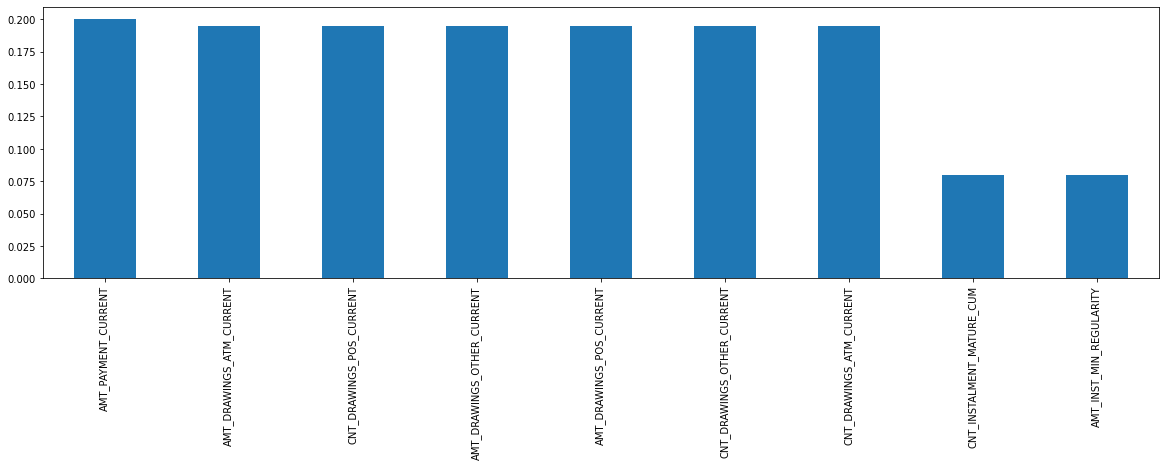

In [71]:
checking_nan(credit_card_balance).info()
checking_nan(credit_card_balance).plot()

In [72]:
# display number of credit card accounts
len(credit_card_balance['SK_ID_PREV'].unique())

104307

In [73]:
# display number of clients with credit card accounts
SK_ID_CURR_credit_card = credit_card_balance['SK_ID_CURR'].unique().tolist()
len(SK_ID_CURR_credit_card)
# Most client had only one credit card

103558

In [74]:
# check number of clients that are in application_train and who have credit card history
CURR_ID_with_credit_card = application_train[application_train['SK_ID_CURR'].isin(SK_ID_CURR_credit_card)]
CURR_ID_with_credit_card.shape[0]

86905

### Numerical Variables

In [75]:
cc_num_var = [var for var in credit_card_balance.columns if credit_card_balance.dtypes[var] != 'object']
var_ID = ['SK_ID_CURR','SK_ID_PREV' ]
cc_num_var = [x for x in cc_num_var if x not in var_ID ]
len(cc_num_var )

20

In [76]:
credit_card_balance_eda = application_train[['SK_ID_CURR', 'TARGET']].merge(credit_card_balance, how = 'inner')
credit_card_balance_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100006,0,1489396,-2,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
1,100006,0,1489396,-1,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
2,100006,0,1489396,-5,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
3,100006,0,1489396,-3,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0
4,100006,0,1489396,-4,0.0,270000,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0,NaN,NaN,0.0,Active,0,0


In [77]:
credit_card_balance_eda.shape

(3227965, 24)

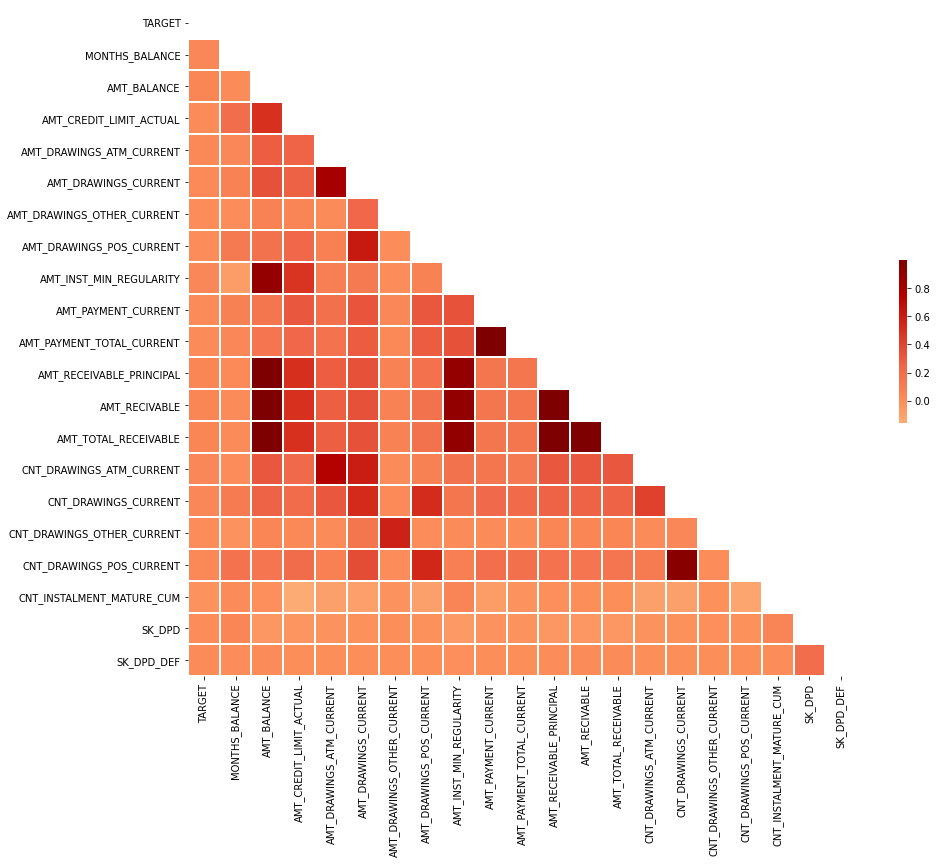

In [608]:
correlation_matrix(credit_card_balance_eda, cc_num_var).heatmap()

In [609]:
correlation_matrix(credit_card_balance_eda, cc_num_var).top_corr_var()

,Phik-Correlation
AMT_BALANCE,0.059838
AMT_RECIVABLE,0.059311
AMT_TOTAL_RECEIVABLE,0.059287
AMT_RECEIVABLE_PRINCIPAL,0.058895
MONTHS_BALANCE,0.05036
AMT_INST_MIN_REGULARITY,0.042174
CNT_INSTALMENT_MATURE_CUM,0.038261
CNT_DRAWINGS_ATM_CURRENT,0.030052
AMT_CREDIT_LIMIT_ACTUAL,0.028752
CNT_DRAWINGS_CURRENT,0.027868


In [92]:
# group by credit card and take mean of values
cc_groupby_mean = credit_card_balance_eda.groupby('SK_ID_PREV').mean()
cc_groupby_mean['TARGET'] = cc_groupby_mean['TARGET'].astype('int').astype('category')
cc_groupby_mean.head(5)

,SK_ID_CURR,TARGET,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,,,,,,,,,,,,,,,,
1000018,394447.0,0,-4.0,74946.285000,81000.000000,5400.000000,29478.996000,0.0,24078.996000,2594.08800,5541.750000,5541.7500,72298.197000,73602.585000,73602.585000,1.200000,8.800,0.0,7.600000,2.000,0.0,0.0
1000030,361282.0,0,-4.5,55991.064375,81562.500000,642.857143,17257.438125,0.0,19079.929286,2078.22375,6188.631429,2657.9475,55474.453125,55935.376875,55935.376875,0.142857,5.125,0.0,5.714286,1.875,0.0,0.0
1000035,436351.0,0,-4.0,0.000000,225000.000000,NaN,0.000000,NaN,NaN,0.00000,NaN,0.0000,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0
1000077,181153.0,0,-7.0,0.000000,94090.909091,NaN,0.000000,NaN,NaN,0.00000,NaN,0.0000,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0
1000083,309691.0,0,-7.0,0.000000,183461.538462,NaN,0.000000,NaN,NaN,0.00000,NaN,0.0000,0.000000,0.000000,0.000000,NaN,0.000,NaN,NaN,0.000,0.0,0.0


In [93]:
correlation_matrix(cc_groupby_mean, cc_num_var).top_corr_var()

,Phik-Correlation
AMT_BALANCE,0.11771
AMT_RECIVABLE,0.117688
AMT_TOTAL_RECEIVABLE,0.117667
AMT_RECEIVABLE_PRINCIPAL,0.117472
AMT_INST_MIN_REGULARITY,0.08828
MONTHS_BALANCE,0.082091
CNT_INSTALMENT_MATURE_CUM,0.052574
CNT_DRAWINGS_ATM_CURRENT,0.042586
CNT_DRAWINGS_CURRENT,0.040082
CNT_DRAWINGS_POS_CURRENT,0.028772


In [80]:
cc_top_num_var = ['AMT_BALANCE','AMT_RECIVABLE', 'AMT_INST_MIN_REGULARITY',
                  'MONTHS_BALANCE', 'CNT_INSTALMENT_MATURE_CUM']

AMT_BALANCE


'Balance during the month of previous credit'

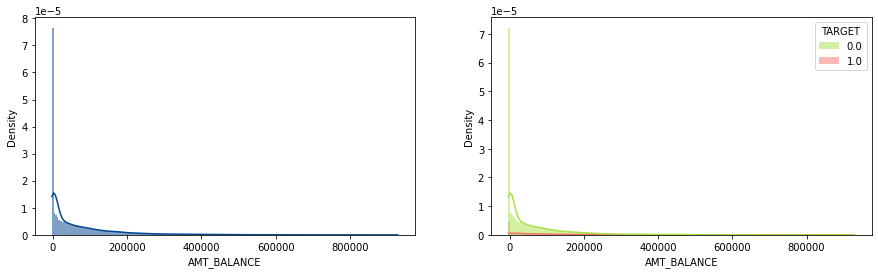

AMT_RECIVABLE


'Amount receivable on the previous credit'

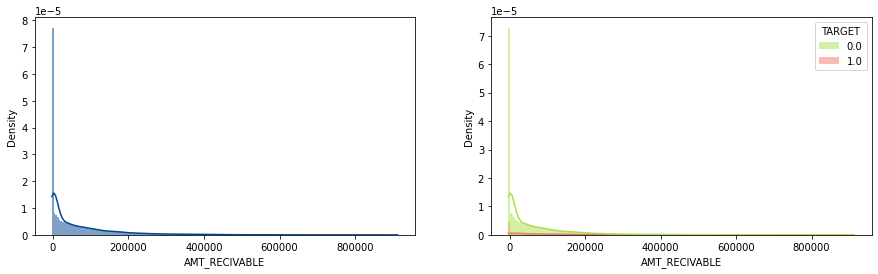

AMT_INST_MIN_REGULARITY


'Minimal installment for this month of the previous credit'

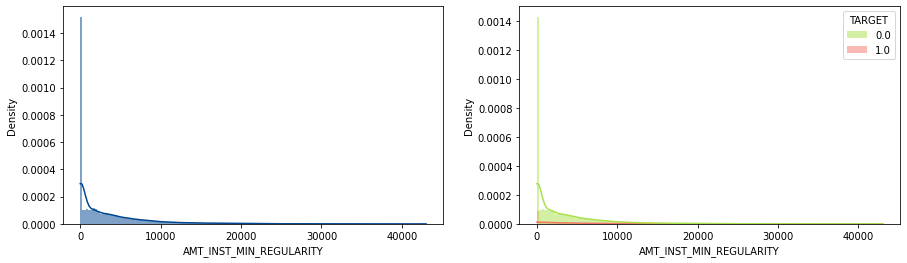

MONTHS_BALANCE


'Month of balance relative to application date (-1 means the freshest balance date)'

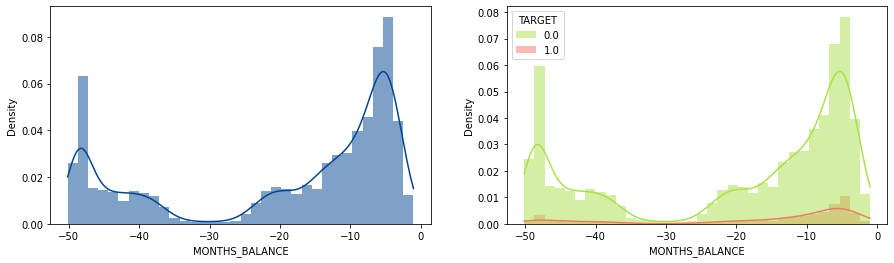

CNT_INSTALMENT_MATURE_CUM


'Number of paid installments on the previous credit'

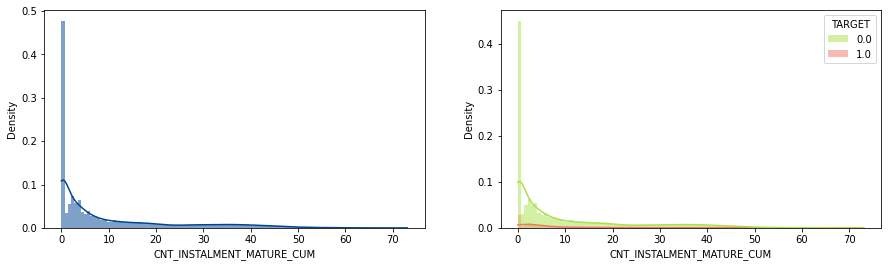

In [615]:
# distribution plots
for col in cc_top_num_var : 
    print(col)
    display_var_def(col)
    
    plt.figure(figsize = (15,4))
    plt.subplot(121)
    sns.histplot(x = col, data = cc_groupby_mean, kde = True, stat="density", linewidth=0,
             color = dark_blue)
    plt.subplot(122)
    sns.histplot(x = col, data = cc_groupby_mean, hue = 'TARGET', kde = True, stat="density", linewidth=0, 
             palette = [green, red])
    plt.show()

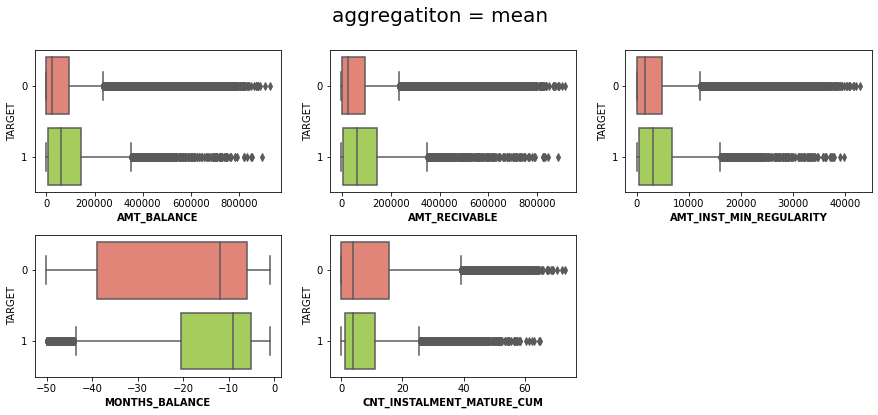

In [119]:
plt.figure(figsize=(15,6))
plt.suptitle('aggregatiton = mean', fontsize = 20)
for i, var in enumerate(cc_top_num_var):
    n = len(cc_top_num_var)
    plt.subplot(int(n/3)+1, 3, i+1)
    customboxplot(cc_groupby_mean, var )
plt.subplots_adjust(hspace = 0.3)

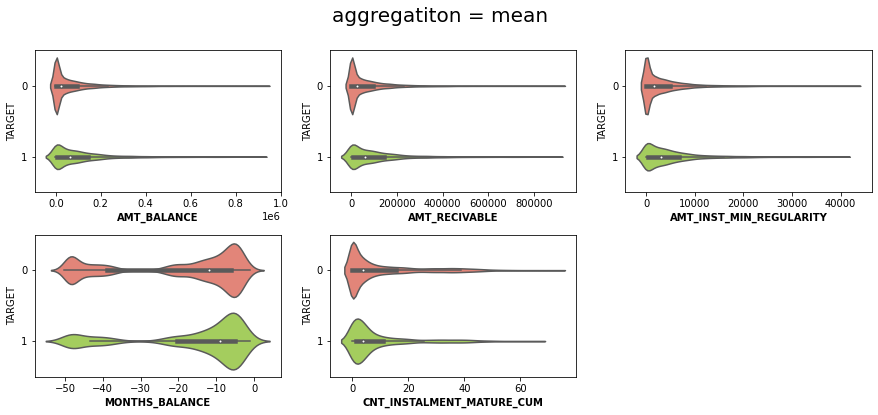

In [125]:
plt.figure(figsize=(15,6))
plt.suptitle('aggregatiton = mean', fontsize = 20)
for i, var in enumerate(cc_top_num_var):
    n = len(cc_top_num_var)
    plt.subplot(int(n/3)+1, 3, i+1)
    customviolinplot(cc_groupby_mean, var )
plt.subplots_adjust(hspace = 0.3)

## installments_payments.csv
This table lists out the repayment history of each of the loan that the applicant had with Home Credit Group

### Shape, Variables & Nan
- Rows and columns : 13 605 401, 8
- Numerical variables: float 5 / int 3
- No duplicated rows
- 2 columns with Nan (<1%)

In [104]:
installments_payments.shape

(13605401, 8)

In [106]:
installments_payments.dtypes.value_counts()

float64    5
int64      3
dtype: int64

In [102]:
installments_payments.head(5)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [107]:
installments_payments.duplicated().value_counts()

False    13605401
dtype: int64

In [110]:
checking_nan(installments_payments).info()
checking_nan(installments_payments).percent_nan

Number of columns with NaN: 2 / 8 columns


DAYS_ENTRY_PAYMENT        0.000214
AMT_PAYMENT               0.000214
SK_ID_PREV                0.000000
SK_ID_CURR                0.000000
NUM_INSTALMENT_VERSION    0.000000
NUM_INSTALMENT_NUMBER     0.000000
DAYS_INSTALMENT           0.000000
AMT_INSTALMENT            0.000000
dtype: float64

### Numerical variables

In [127]:
len(installments_payments['SK_ID_CURR'].unique())

339587

In [134]:
var_ID = ['SK_ID_CURR','SK_ID_PREV' ]
installments_num_var = [x for x in installments_payments.columns if x not in var_ID ]
len(installments_num_var)

6

In [133]:
installments_payments_eda = application_train[['SK_ID_CURR', 'TARGET']].merge(installments_payments, how = 'inner')
installments_payments_eda['YEARS_INSTALMENT'] = installments_payments['DAYS_INSTALMENT'] * -1 / 365
installments_payments_eda['YEARS_ENTRY_PAYMENT'] = installments_payments['DAYS_ENTRY_PAYMENT'] * -1 / 365
installments_payments_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,YEARS_INSTALMENT,YEARS_ENTRY_PAYMENT
0,100002,1,1038818,1.0,16,-115.0,-133.0,9251.775,9251.775,3.232877,3.252055
1,100002,1,1038818,1.0,8,-355.0,-375.0,9251.775,9251.775,5.906849,5.906849
2,100002,1,1038818,2.0,19,-25.0,-49.0,53093.745,53093.745,0.172603,0.172603
3,100002,1,1038818,1.0,12,-235.0,-250.0,9251.775,9251.775,6.624658,6.646575
4,100002,1,1038818,1.0,9,-325.0,-344.0,9251.775,9251.775,3.789041,3.742466


In [135]:
replacements = {
    'DAYS_INSTALMENT': 'YEARS_INSTALMENT',
    'DAYS_ENTRY_PAYMENT': 'YEARS_ENTRY_PAYMENT'}

installments_num_var_fe  = [replacements.get(x, x) for x in installments_num_var ]

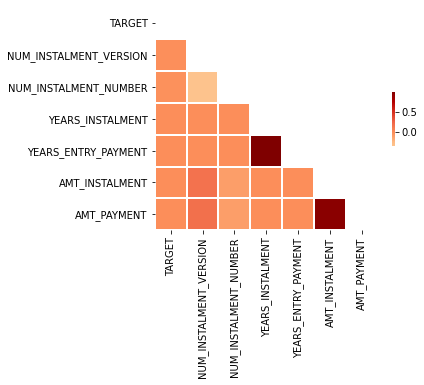

In [140]:
correlation_matrix(installments_payments_eda, installments_num_var_fe).heatmap(figsize = (5,5))

In [143]:
# group by SK_ID_PREV and take mean of values
instalments_groupby_mean = installments_payments_eda.groupby('SK_ID_PREV').mean()
instalments_groupby_mean['TARGET'] = instalments_groupby_mean['TARGET'].astype('int').astype('category')
instalments_groupby_mean.head(5)

,SK_ID_CURR,TARGET,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,YEARS_INSTALMENT,YEARS_ENTRY_PAYMENT
SK_ID_PREV,,,,,,,,,,
1000001,158271.0,0,1.500000,1.500000,-253.000000,-269.000000,34221.712500,34221.712500,2.860274,2.869863
1000003,252457.0,0,1.000000,2.000000,-64.000000,-79.333333,4951.350000,4951.350000,2.717808,2.758904
1000004,260094.0,0,1.142857,4.000000,-772.000000,-798.714286,4789.022143,4789.022143,2.693933,2.733464
1000005,176456.0,0,1.000000,5.818182,-1543.454545,-1551.909091,14703.210000,13365.609545,1.914570,1.934994
1000007,256657.0,0,1.000000,3.000000,-63.000000,-79.800000,11246.805000,11246.805000,1.932055,2.015890


In [157]:
correlation_matrix(installments_payments_eda, installments_num_var).top_corr_var()

,Phik-Correlation
DAYS_INSTALMENT,0.046824
DAYS_ENTRY_PAYMENT,0.033128
NUM_INSTALMENT_NUMBER,0.022993
AMT_INSTALMENT,0.004125
AMT_PAYMENT,0.003084
NUM_INSTALMENT_VERSION,0.002198


In [154]:
correlation_matrix(instalments_groupby_mean, installments_num_var_fe).top_corr_var()

,Phik-Correlation
NUM_INSTALMENT_NUMBER,0.023453
AMT_INSTALMENT,0.005077
YEARS_ENTRY_PAYMENT,0.004707
NUM_INSTALMENT_VERSION,0.004666
AMT_PAYMENT,0.004632
YEARS_INSTALMENT,0.004517


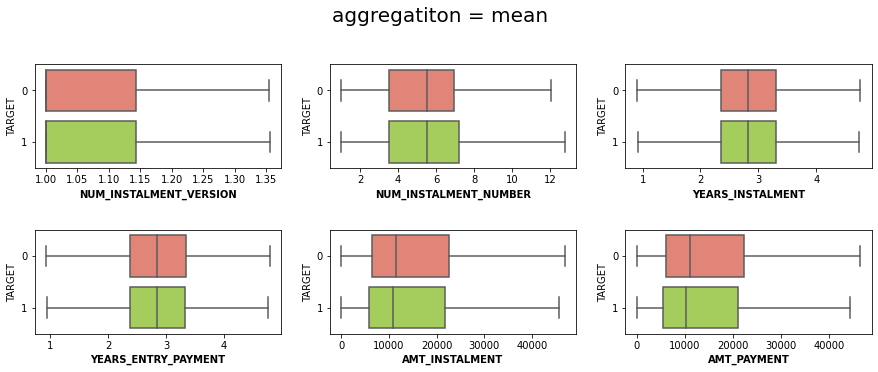

In [153]:
plt.figure(figsize=(15,8))
plt.suptitle('aggregation = mean', fontsize = 20)
for i, var in enumerate(installments_num_var_fe):
    n = len(installments_num_var_fe)
    plt.subplot(int(n/3)+1, 3, i+1)
    customboxplot(instalments_groupby_mean, var, Fliers = False)
plt.subplots_adjust(hspace = 0.6)

## POS_CASH_balance.csv
This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group

### Shape, Variables & Nan
- Rows and columns : 10 001 358, 8
- Numerical variables: float 2 / int 5, categorical variables : 1
- No duplicated rows
- 2 columns with Nan (<1%)

In [111]:
POS_CASH_balance.head(5)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [112]:
POS_CASH_balance.shape

(10001358, 8)

In [113]:
POS_CASH_balance.dtypes.value_counts()

int64      5
float64    2
object     1
dtype: int64

In [114]:
POS_CASH_balance.duplicated().value_counts()

False    10001358
dtype: int64

In [116]:
checking_nan(POS_CASH_balance).info()
checking_nan(POS_CASH_balance).percent_nan

Number of columns with NaN: 2 / 8 columns


CNT_INSTALMENT_FUTURE    0.002608
CNT_INSTALMENT           0.002607
SK_ID_PREV               0.000000
SK_ID_CURR               0.000000
MONTHS_BALANCE           0.000000
NAME_CONTRACT_STATUS     0.000000
SK_DPD                   0.000000
SK_DPD_DEF               0.000000
dtype: float64

In [159]:
POS_CASH_balance['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

### Numerical variables

In [163]:
POS_CASH_eda = application_train[['SK_ID_CURR', 'TARGET']].merge(POS_CASH_balance, how = 'inner')
POS_CASH_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,100002,1,1038818,-13,24.0,18.0,Active,0,0
1,100002,1,1038818,-16,24.0,21.0,Active,0,0
2,100002,1,1038818,-18,24.0,23.0,Active,0,0
3,100002,1,1038818,-17,24.0,22.0,Active,0,0
4,100002,1,1038818,-5,24.0,10.0,Active,0,0


In [164]:
POS_CASH_num_var = [var for var in POS_CASH_balance.columns if POS_CASH_balance.dtypes[var] != 'object']
var_ID = ['SK_ID_CURR','SK_ID_PREV' ]
POS_CASH_num_var = [x for x in POS_CASH_num_var if x not in var_ID ]
len(POS_CASH_num_var)

5

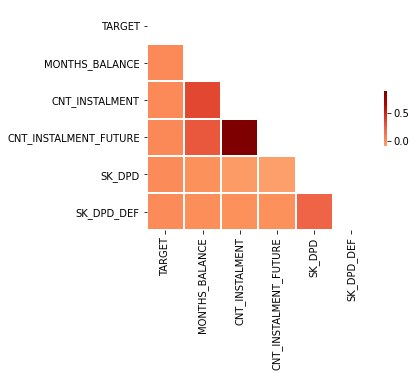

In [166]:
correlation_matrix(POS_CASH_eda, POS_CASH_num_var).heatmap(figsize = (5,5))

In [167]:
correlation_matrix(POS_CASH_eda, POS_CASH_num_var).top_corr_var()

,Phik-Correlation
CNT_INSTALMENT_FUTURE,0.033194
CNT_INSTALMENT,0.030947
MONTHS_BALANCE,0.027391
SK_DPD,0.012773
SK_DPD_DEF,0.010539


In [165]:
# group by SK_ID_PREV and take mean of values
POS_CASH_groupby_mean = POS_CASH_eda.groupby('SK_ID_PREV').mean()
POS_CASH_groupby_mean['TARGET'] = POS_CASH_groupby_mean['TARGET'].astype('int').astype('category')
POS_CASH_groupby_mean.head(5)

,SK_ID_CURR,TARGET,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
SK_ID_PREV,,,,,,,
1000001,158271.0,0,-9.0,8.666667,7.666667,0.0,0.0
1000003,252457.0,0,-2.5,12.000000,10.500000,0.0,0.0
1000004,260094.0,0,-25.5,9.625000,6.125000,0.0,0.0
1000005,176456.0,0,-51.0,10.000000,5.000000,0.0,0.0
1000007,256657.0,0,-3.0,6.000000,4.000000,0.0,0.0


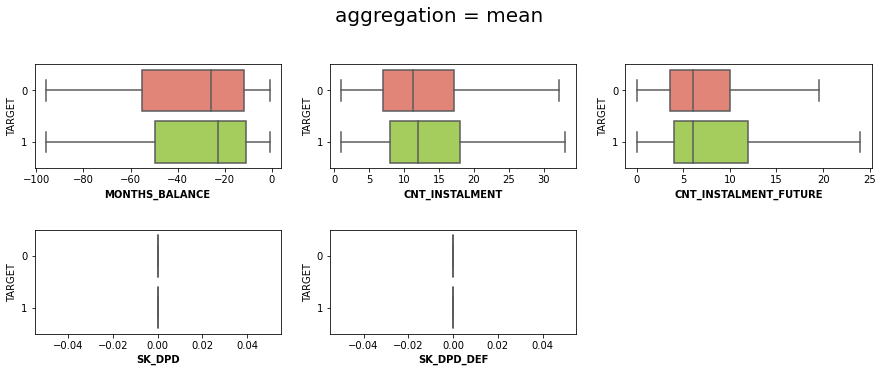

In [168]:
plt.figure(figsize=(15,8))
df = POS_CASH_groupby_mean
cols = POS_CASH_num_var
plt.suptitle('aggregation = mean', fontsize = 20)
for i, var in enumerate(cols):
    n = len(installments_num_var_fe)
    plt.subplot(int(n/3)+1, 3, i+1)
    customboxplot(df, var, Fliers = False)
plt.subplots_adjust(hspace = 0.6)

## previous_application.csv
This table contains the static data of the previous loan which the client had with Home Credit.

### Shape, Variables & Nans
- Rows and columns : 1 670 214, 37
- Numerical variables: float 15 / int 6, categorical variables : 16
- No duplicated rows
- 16 columns with Nan (100% for 2 columns, max 50% otherwise)

In [117]:
previous_application.head(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
previous_application.shape

(1670214, 37)

In [119]:
previous_application.dtypes.value_counts()

object     16
float64    15
int64       6
dtype: int64

In [120]:
previous_application.duplicated().value_counts()

False    1670214
dtype: int64

Number of columns with NaN: 16 / 37 columns


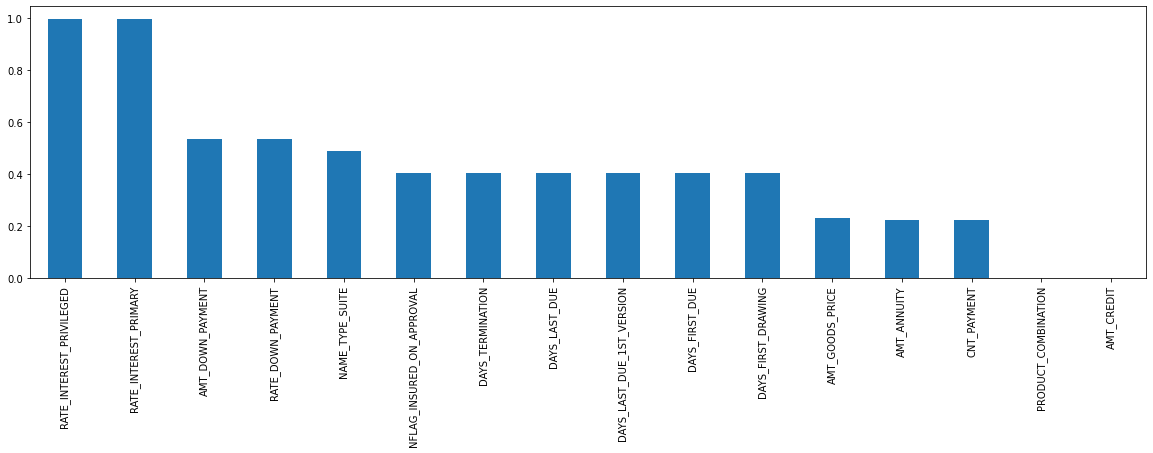

In [122]:
checking_nan(previous_application).info()
checking_nan(previous_application).plot()

In [188]:
# make a list of variables with less than 20% Nan
prev_app_percent_nan = checking_nan(previous_application).percent_nan
prev_app_var_to_keep = prev_app_percent_nan[prev_app_percent_nan <0.2].index.tolist()
prev_app_var_to_keep = [x for x in prev_app_var_to_keep if x != 'SK_ID_CURR']

In [169]:
len(previous_application['SK_ID_PREV'].unique())

1670214

In [170]:
len(previous_application['SK_ID_CURR'].unique())

338857

In [178]:
SK_ID_CURR_application = application_train['SK_ID_CURR'].unique().tolist()
len(SK_ID_CURR_application)

307511

In [175]:
len(set(previous_application['SK_ID_CURR'].unique()).intersection(set(SK_ID_CURR_application)))
# Most clients had a previous loan with Home Credit

291057

In [179]:
previous_application_eda = application_train[['SK_ID_CURR', 'TARGET']].merge(previous_application, how = 'inner')
previous_application_eda.head()

,SK_ID_CURR,TARGET,SK_ID_PREV,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,1038818,Consumer loans,9251.775,179055.0,179055.0,0.0,179055.0,SATURDAY,9,Y,1,0.000000,NaN,NaN,XAP,Approved,-606,XNA,XAP,NaN,New,Vehicles,POS,XNA,Stone,500,Auto technology,24.0,low_normal,POS other with interest,365243.0,-565.0,125.0,-25.0,-17.0,0.0
1,100003,0,1810518,Cash loans,98356.995,900000.0,1035882.0,NaN,900000.0,FRIDAY,12,Y,1,NaN,NaN,NaN,XNA,Approved,-746,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-716.0,-386.0,-536.0,-527.0,1.0
2,100003,0,2636178,Consumer loans,64567.665,337500.0,348637.5,0.0,337500.0,SUNDAY,17,Y,1,0.000000,NaN,NaN,XAP,Approved,-828,Cash through the bank,XAP,Family,Refreshed,Furniture,POS,XNA,Stone,1400,Furniture,6.0,middle,POS industry with interest,365243.0,-797.0,-647.0,-647.0,-639.0,0.0
3,100003,0,2396755,Consumer loans,6737.310,68809.5,68053.5,6885.0,68809.5,SATURDAY,15,Y,1,0.100061,NaN,NaN,XAP,Approved,-2341,Cash through the bank,XAP,Family,Refreshed,Consumer Electronics,POS,XNA,Country-wide,200,Consumer electronics,12.0,middle,POS household with interest,365243.0,-2310.0,-1980.0,-1980.0,-1976.0,1.0
4,100004,0,1564014,Consumer loans,5357.250,24282.0,20106.0,4860.0,24282.0,FRIDAY,5,Y,1,0.212008,NaN,NaN,XAP,Approved,-815,Cash through the bank,XAP,Unaccompanied,New,Mobile,POS,XNA,Regional / Local,30,Connectivity,4.0,middle,POS mobile without interest,365243.0,-784.0,-694.0,-724.0,-714.0,0.0


### Numerical Variables

In [184]:
# make a list variables and remove ID variable
prev_app_var = previous_application_eda.columns
prev_app_var = [x for x in prev_app_var if x not in ['SK_ID_CURR', 'SK_ID_PREV', 'TARGET']]

# make a list of categorical variables
prev_app_cat_var = [col for col in prev_app_var if previous_application_eda.dtypes[col] == 'object']\
    + ['NFLAG_INSURED_ON_APPROVAL']

# make a list of numerical variables
prev_app_num_var = [col for col in prev_app_var if col not in prev_app_cat_var ]

In [186]:
len(prev_app_num_var)

18

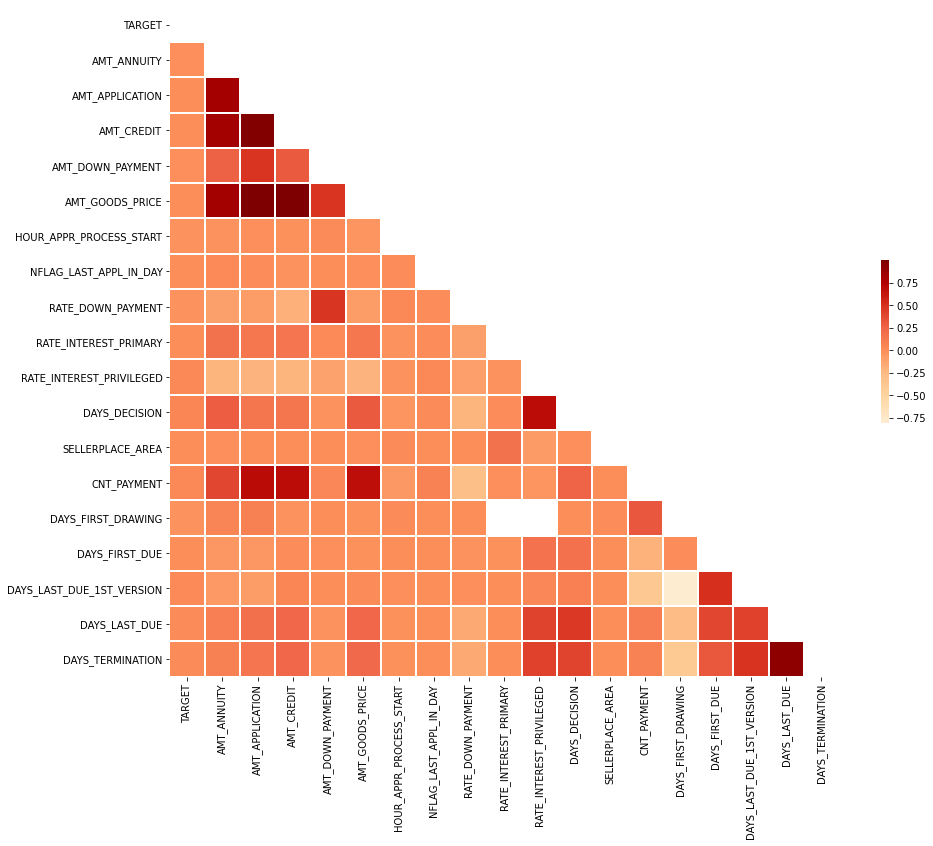

In [187]:
correlation_matrix(previous_application_eda, prev_app_num_var).heatmap()

In [195]:
prev_app_num_var_to_keep = list(set(prev_app_num_var).intersection(prev_app_var_to_keep))

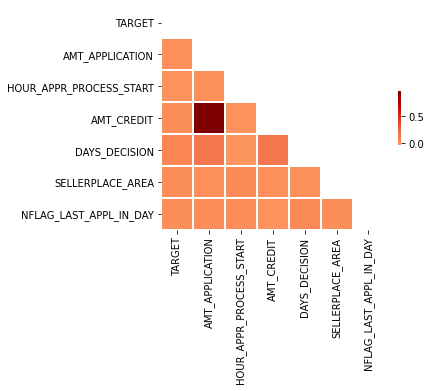

In [197]:
correlation_matrix(previous_application_eda, prev_app_num_var_to_keep).heatmap(figsize=(5,5))

In [ ]:
prev_app_df_top_num_var = correlation_matrix(previous_application_eda, prev_app_num_var_to_keep).top_corr_var(10)
display(prev_app_df_top_num_var)

### Categorical Variables 

In [ ]:
phik_matrix(previous_application_eda, prev_app_cat_var).heatmap()

In [200]:
prev_app_cat_var_to_keep = list(set(prev_app_cat_var).intersection(prev_app_var_to_keep))

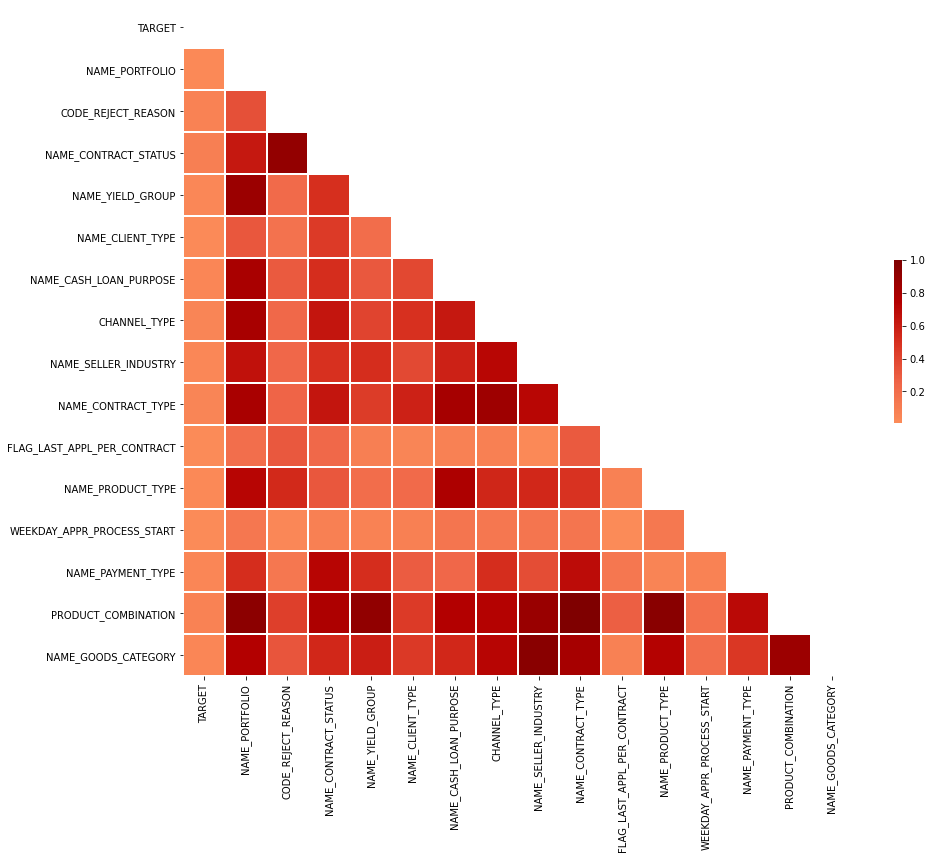

In [201]:
phik_matrix(previous_application_eda, prev_app_cat_var_to_keep).heatmap()

In [202]:
prev_app_df_top_cat_var = phik_matrix(previous_application_eda, prev_app_cat_var_to_keep).top_corr_var()
display(prev_app_df_top_cat_var)

,Phik-Correlation
NAME_CONTRACT_STATUS,0.088266
PRODUCT_COMBINATION,0.063839
CODE_REJECT_REASON,0.062771
NAME_CONTRACT_TYPE,0.050859
CHANNEL_TYPE,0.050302
NAME_GOODS_CATEGORY,0.042951
NAME_CASH_LOAN_PURPOSE,0.040305
NAME_PAYMENT_TYPE,0.039752
NAME_SELLER_INDUSTRY,0.038077
NAME_YIELD_GROUP,0.034626


In [205]:
prev_app_top_cat_var = prev_app_df_top_cat_var.index.tolist()

NAME_CONTRACT_STATUS
Number of unique categories: 4


'Contract status during the month'

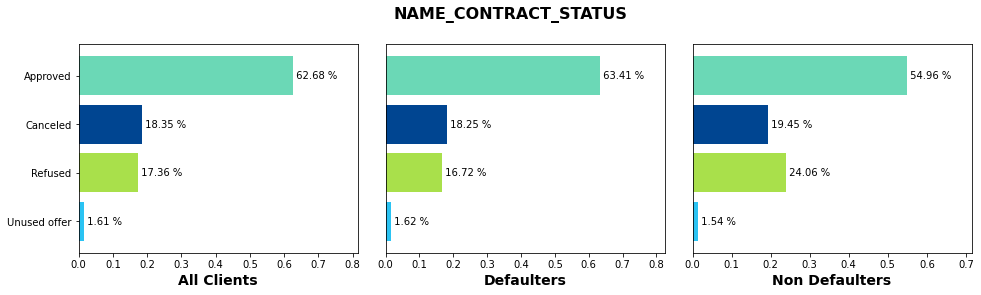

PRODUCT_COMBINATION
Number of unique categories: 18


'Detailed product combination of the previous application'

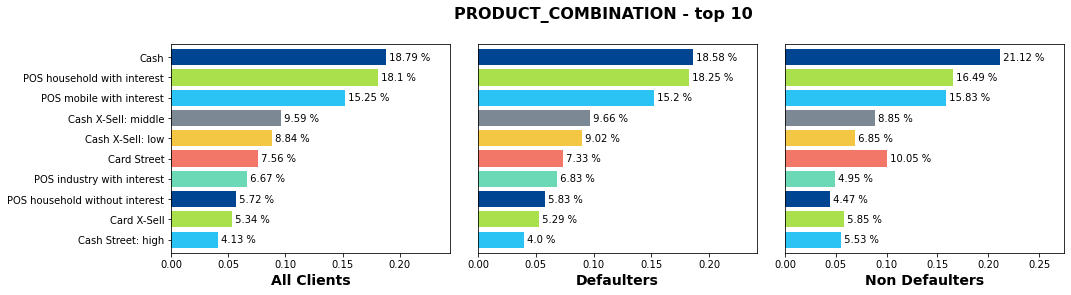

CODE_REJECT_REASON
Number of unique categories: 9


'Why was the previous application rejected'

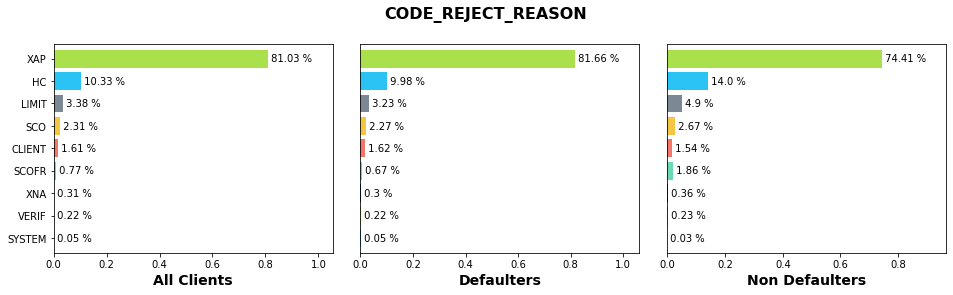

NAME_CONTRACT_TYPE
Number of unique categories: 4


'Identification if loan is cash or revolving'

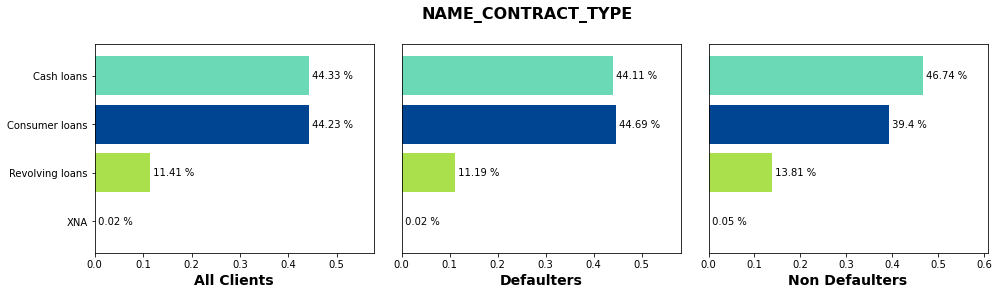

CHANNEL_TYPE
Number of unique categories: 8


'Through which channel we acquired the client on the previous application'

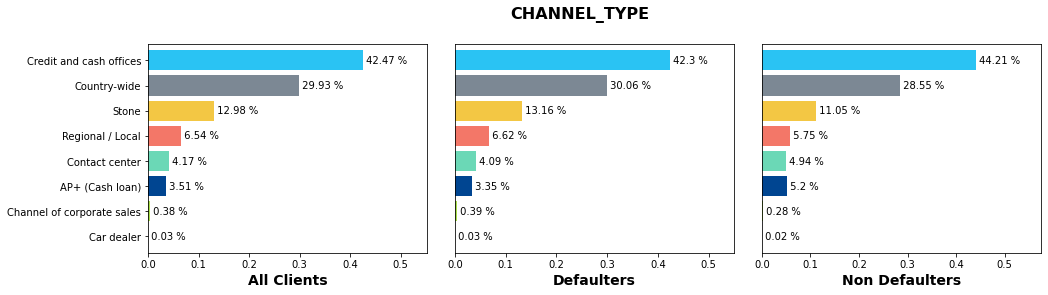

NAME_GOODS_CATEGORY
Number of unique categories: 27


'What kind of goods did the client apply for in the previous application'

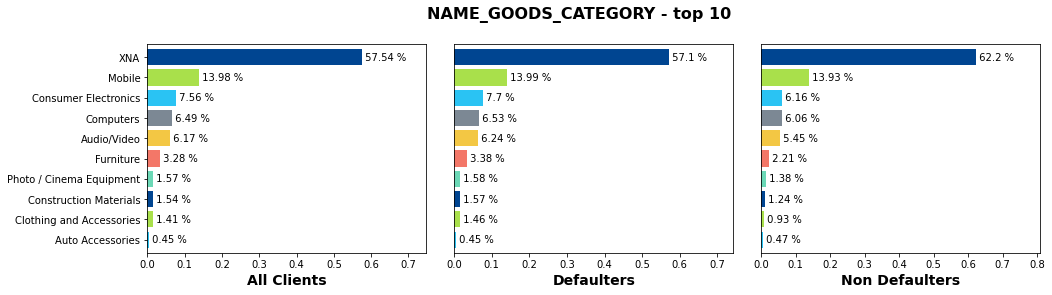

NAME_CASH_LOAN_PURPOSE
Number of unique categories: 25


'Purpose of the cash loan'

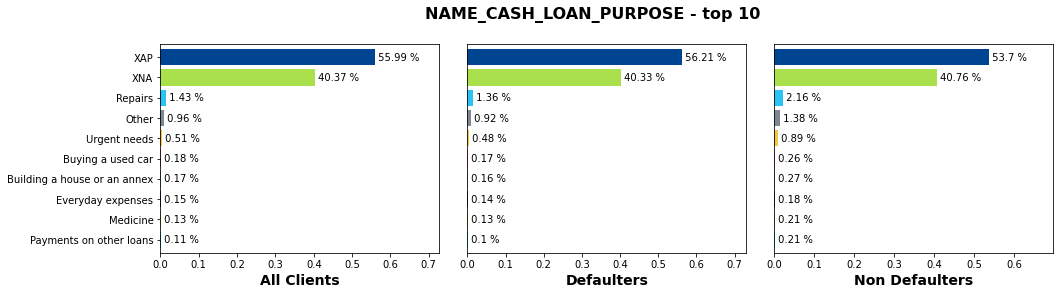

NAME_PAYMENT_TYPE
Number of unique categories: 4


'Payment method that client chose to pay for the previous application'

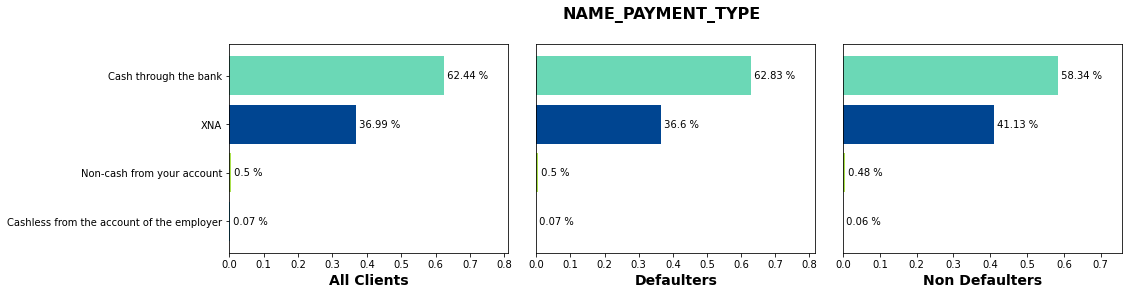

NAME_SELLER_INDUSTRY
Number of unique categories: 11


'The industry of the seller'

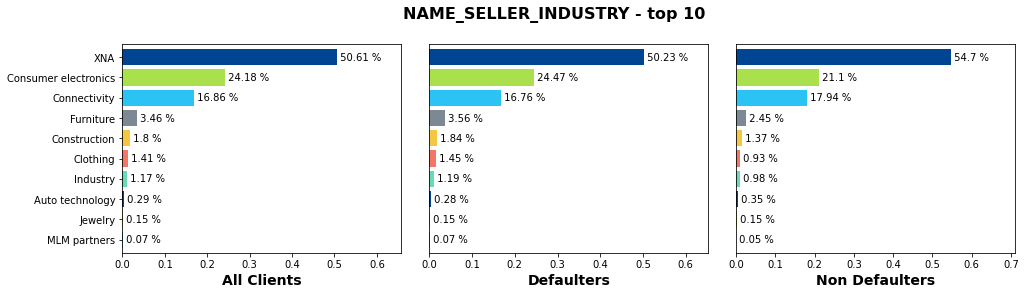

NAME_YIELD_GROUP
Number of unique categories: 5


'Grouped interest rate into small medium and high of the previous application'

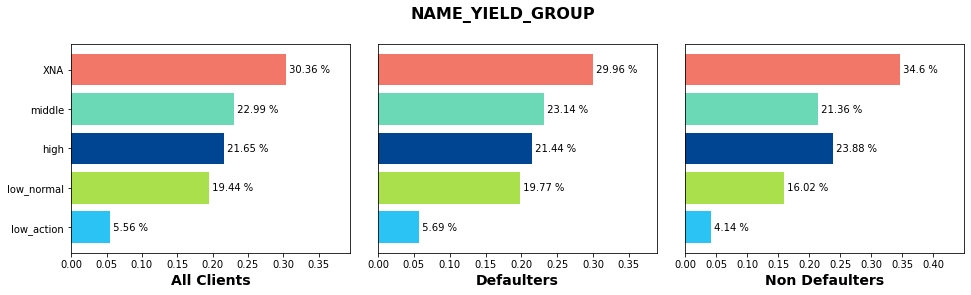

In [206]:
# donut or bar plots for top categorical features
for col in prev_app_top_cat_var : 
    n = len(previous_application_eda[col].unique())
    print(col)
    print('Number of unique categories: {}'.format(n))
    display_var_def(col)
    if n <= 2:
        cat_target_donutplots(previous_application_eda, col)
    else :
        cat_target_barplots(previous_application_eda, col)